# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('se_resnext50_aug_5e-5_3e-4_imgnet')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 33.6 s, sys: 31 s, total: 1min 4s
Wall time: 6.91 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

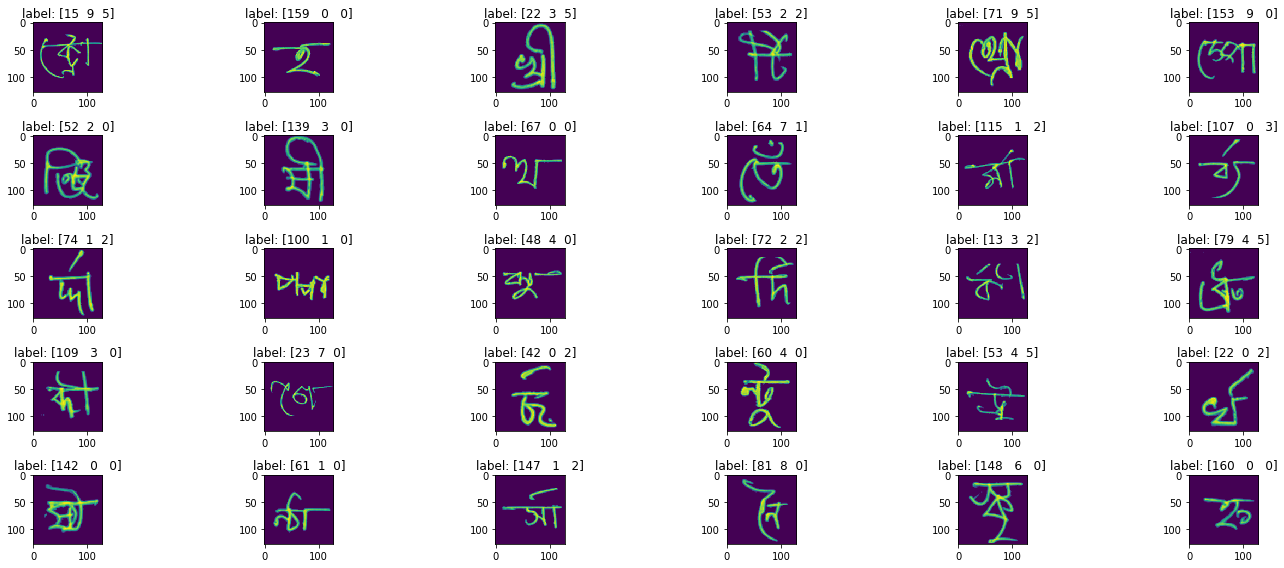

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

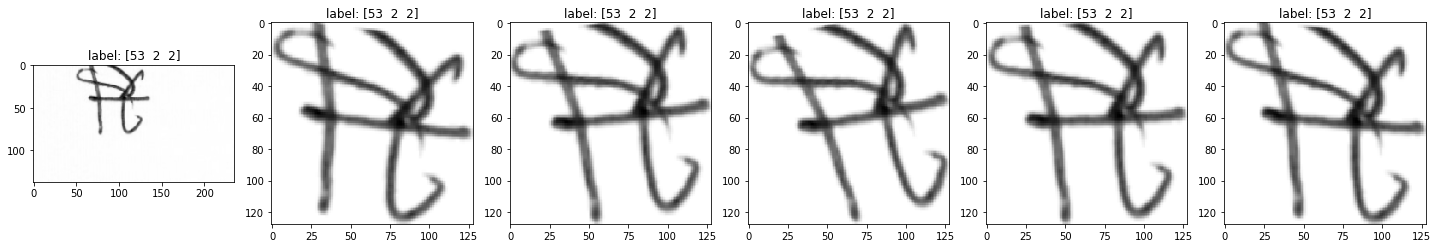

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

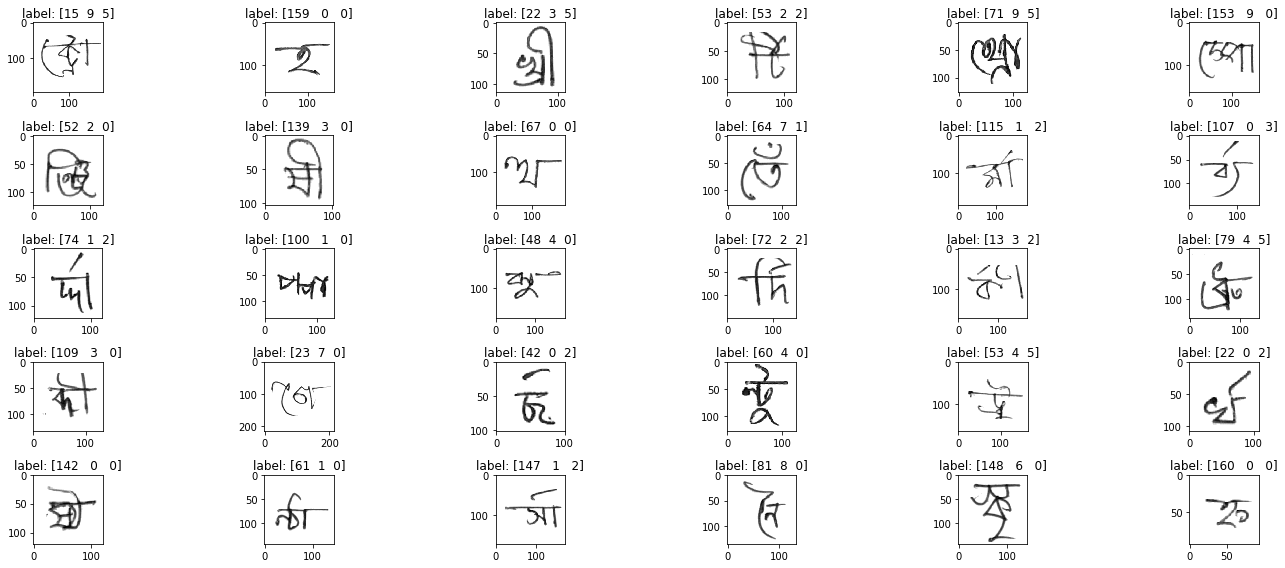

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

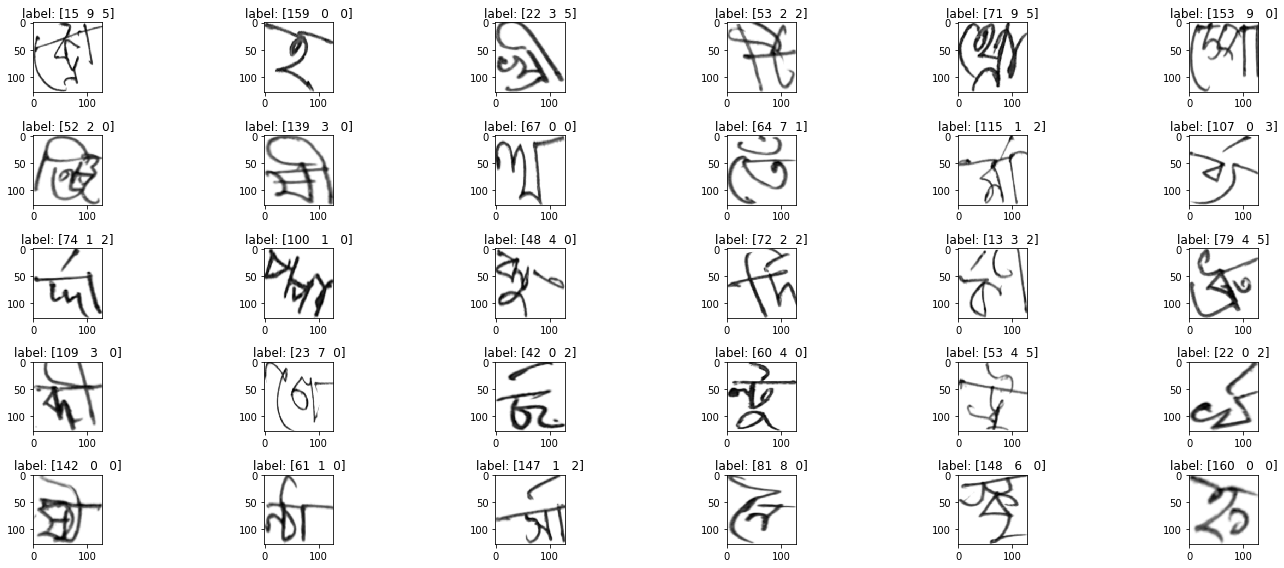

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

TH = 80.0

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [23]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

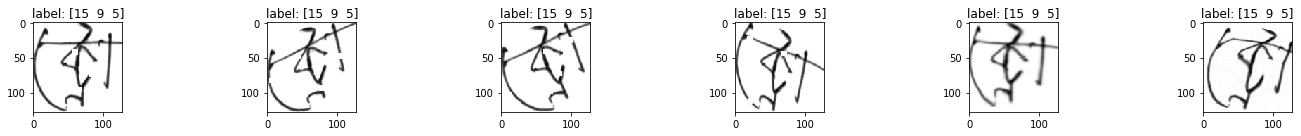

In [24]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

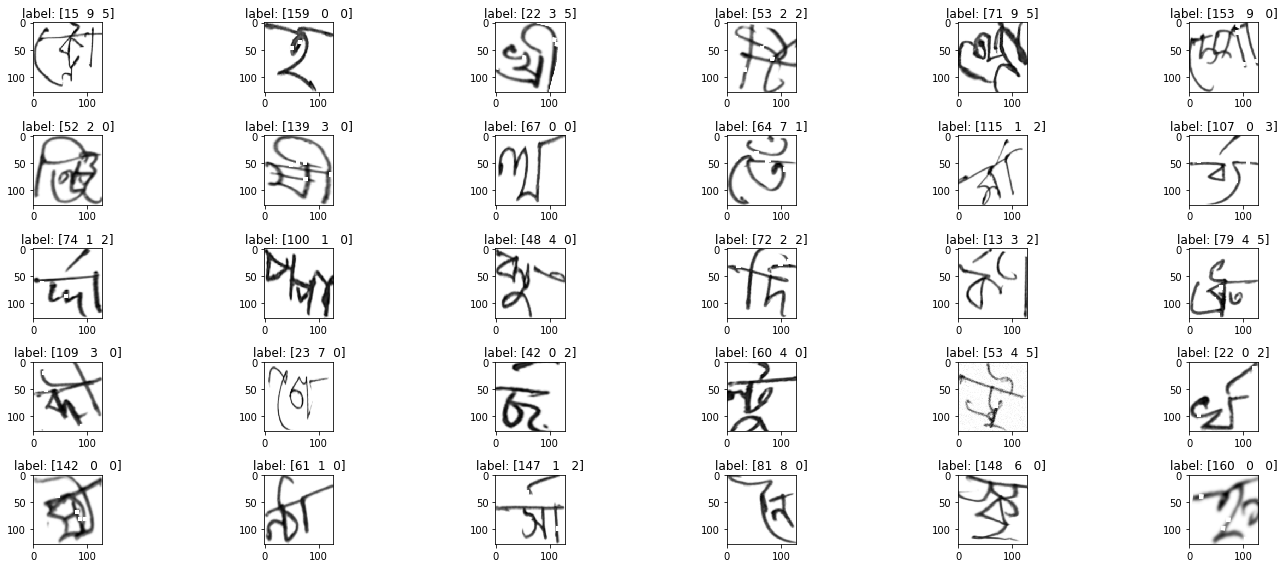

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 2*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [35]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [36]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [37]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [38]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [39]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [40]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [41]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [42]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [43]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [44]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [45]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [46]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [47]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 4
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-5, weight_decay=3e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/2511 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

100%|██████████| 628/628 [01:11<00:00,  8.78it/s]


epoch      0 train/loss  9.969025 train/loss_grapheme  7.087634 train/loss_vowel  1.473640 train/loss_consonant  1.407752 train/acc_grapheme  0.357362 train/acc_vowel  0.715408 train/acc_consonant  0.750616 train/recall  0.432710 val/loss  5.869158 val/loss_grapheme  3.738524 val/loss_vowel  1.016908 val/loss_consonant  1.113726 val/acc_grapheme  0.781791 val/acc_vowel  0.952101 val/acc_consonant  0.947321 val/recall  0.768269 lr  0.000050 elapsed_time  666.864391 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      1 train/loss  6.552450 train/loss_grapheme  4.530522 train/loss_vowel  0.969741 train/loss_consonant  1.052187 train/acc_grapheme  0.729181 train/acc_vowel  0.940736 train/acc_consonant  0.940400 train/recall  0.742241 val/loss  3.961608 val/loss_grapheme  2.330006 val/loss_vowel  0.742611 val/loss_consonant  0.888990 val/acc_grapheme  0.910451 val/acc_vowel  0.979237 val/acc_consonant  0.974034 val/recall  0.902139 lr  0.000050 elapsed_time  1368.390256 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      2 train/loss  5.163265 train/loss_grapheme  3.580755 train/loss_vowel  0.742947 train/loss_consonant  0.839563 train/acc_grapheme  0.839891 train/acc_vowel  0.963018 train/acc_consonant  0.963510 train/recall  0.839867 val/loss  2.948026 val/loss_grapheme  1.677497 val/loss_vowel  0.574796 val/loss_consonant  0.695734 val/acc_grapheme  0.935919 val/acc_vowel  0.982747 val/acc_consonant  0.979486 val/recall  0.929951 lr  0.000050 elapsed_time  2050.600421 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      3 train/loss  4.162386 train/loss_grapheme  2.908834 train/loss_vowel  0.581970 train/loss_consonant  0.671582 train/acc_grapheme  0.882985 train/acc_vowel  0.970206 train/acc_consonant  0.970972 train/recall  0.880181 val/loss  2.252530 val/loss_grapheme  1.281632 val/loss_vowel  0.436179 val/loss_consonant  0.534719 val/acc_grapheme  0.938309 val/acc_vowel  0.984415 val/acc_consonant  0.982025 val/recall  0.935173 lr  0.000050 elapsed_time  2721.547192 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      4 train/loss  3.353140 train/loss_grapheme  2.358151 train/loss_vowel  0.458950 train/loss_consonant  0.536039 train/acc_grapheme  0.909119 train/acc_vowel  0.974862 train/acc_consonant  0.974862 train/recall  0.905182 val/loss  1.744578 val/loss_grapheme  0.979289 val/loss_vowel  0.336248 val/loss_consonant  0.429041 val/acc_grapheme  0.946923 val/acc_vowel  0.984440 val/acc_consonant  0.983967 val/recall  0.942695 lr  0.000050 elapsed_time  3394.481516 mode 011 


100%|██████████| 628/628 [01:10<00:00,  8.95it/s]


epoch      5 train/loss  2.713815 train/loss_grapheme  1.921756 train/loss_vowel  0.365232 train/loss_consonant  0.426827 train/acc_grapheme  0.921772 train/acc_vowel  0.977065 train/acc_consonant  0.978042 train/recall  0.917319 val/loss  1.374352 val/loss_grapheme  0.776528 val/loss_vowel  0.257985 val/loss_consonant  0.339839 val/acc_grapheme  0.949263 val/acc_vowel  0.985984 val/acc_consonant  0.983370 val/recall  0.944211 lr  0.000050 elapsed_time  4064.414763 mode 011 


100%|██████████| 628/628 [01:09<00:00,  9.03it/s]


epoch      6 train/loss  2.228966 train/loss_grapheme  1.591336 train/loss_vowel  0.295930 train/loss_consonant  0.341700 train/acc_grapheme  0.930436 train/acc_vowel  0.978864 train/acc_consonant  0.979187 train/recall  0.926158 val/loss  1.206246 val/loss_grapheme  0.731902 val/loss_vowel  0.207309 val/loss_consonant  0.267035 val/acc_grapheme  0.951031 val/acc_vowel  0.986233 val/acc_consonant  0.985660 val/recall  0.948008 lr  0.000050 elapsed_time  4729.281654 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      7 train/loss  1.840918 train/loss_grapheme  1.324737 train/loss_vowel  0.242543 train/loss_consonant  0.273638 train/acc_grapheme  0.937606 train/acc_vowel  0.980102 train/acc_consonant  0.981123 train/recall  0.933475 val/loss  1.036129 val/loss_grapheme  0.658384 val/loss_vowel  0.165008 val/loss_consonant  0.212737 val/acc_grapheme  0.953570 val/acc_vowel  0.985984 val/acc_consonant  0.984739 val/recall  0.950016 lr  0.000050 elapsed_time  5395.396857 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      8 train/loss  1.540802 train/loss_grapheme  1.117278 train/loss_vowel  0.201482 train/loss_consonant  0.222042 train/acc_grapheme  0.942846 train/acc_vowel  0.981254 train/acc_consonant  0.981982 train/recall  0.938650 val/loss  0.932291 val/loss_grapheme  0.625340 val/loss_vowel  0.136172 val/loss_consonant  0.170778 val/acc_grapheme  0.954541 val/acc_vowel  0.986930 val/acc_consonant  0.985984 val/recall  0.950901 lr  0.000050 elapsed_time  6064.630591 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      9 train/loss  1.305258 train/loss_grapheme  0.953912 train/loss_vowel  0.170036 train/loss_consonant  0.181310 train/acc_grapheme  0.947657 train/acc_vowel  0.982268 train/acc_consonant  0.983382 train/recall  0.943785 val/loss  0.915720 val/loss_grapheme  0.651045 val/loss_vowel  0.120114 val/loss_consonant  0.144560 val/acc_grapheme  0.953470 val/acc_vowel  0.987104 val/acc_consonant  0.985859 val/recall  0.950509 lr  0.000050 elapsed_time  6732.389777 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     10 train/loss  1.137190 train/loss_grapheme  0.841810 train/loss_vowel  0.144673 train/loss_consonant  0.150707 train/acc_grapheme  0.949742 train/acc_vowel  0.983015 train/acc_consonant  0.984210 train/recall  0.945778 val/loss  0.843546 val/loss_grapheme  0.616816 val/loss_vowel  0.107216 val/loss_consonant  0.119513 val/acc_grapheme  0.953943 val/acc_vowel  0.986656 val/acc_consonant  0.986432 val/recall  0.950924 lr  0.000050 elapsed_time  7400.991037 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     11 train/loss  0.994969 train/loss_grapheme  0.741233 train/loss_vowel  0.127283 train/loss_consonant  0.126453 train/acc_grapheme  0.952120 train/acc_vowel  0.983918 train/acc_consonant  0.984795 train/recall  0.948346 val/loss  0.801632 val/loss_grapheme  0.603513 val/loss_vowel  0.091335 val/loss_consonant  0.106784 val/acc_grapheme  0.954840 val/acc_vowel  0.987801 val/acc_consonant  0.986283 val/recall  0.952043 lr  0.000050 elapsed_time  8066.756294 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     12 train/loss  0.882906 train/loss_grapheme  0.661879 train/loss_vowel  0.112145 train/loss_consonant  0.108882 train/acc_grapheme  0.954721 train/acc_vowel  0.984733 train/acc_consonant  0.985442 train/recall  0.950682 val/loss  0.747836 val/loss_grapheme  0.576763 val/loss_vowel  0.080524 val/loss_consonant  0.090549 val/acc_grapheme  0.954466 val/acc_vowel  0.988224 val/acc_consonant  0.986183 val/recall  0.951520 lr  0.000050 elapsed_time  8735.347838 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     13 train/loss  0.790857 train/loss_grapheme  0.595413 train/loss_vowel  0.101004 train/loss_consonant  0.094440 train/acc_grapheme  0.957167 train/acc_vowel  0.984932 train/acc_consonant  0.986071 train/recall  0.953031 val/loss  0.739963 val/loss_grapheme  0.579726 val/loss_vowel  0.077613 val/loss_consonant  0.082624 val/acc_grapheme  0.954840 val/acc_vowel  0.987602 val/acc_consonant  0.985909 val/recall  0.951533 lr  0.000050 elapsed_time  9401.010498 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     14 train/loss  0.721695 train/loss_grapheme  0.544310 train/loss_vowel  0.092638 train/loss_consonant  0.084747 train/acc_grapheme  0.958929 train/acc_vowel  0.985660 train/acc_consonant  0.985990 train/recall  0.955270 val/loss  0.728645 val/loss_grapheme  0.579194 val/loss_vowel  0.069922 val/loss_consonant  0.079529 val/acc_grapheme  0.955835 val/acc_vowel  0.987901 val/acc_consonant  0.985536 val/recall  0.952812 lr  0.000050 elapsed_time  10072.380994 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     15 train/loss  0.657984 train/loss_grapheme  0.496839 train/loss_vowel  0.084055 train/loss_consonant  0.077090 train/acc_grapheme  0.961213 train/acc_vowel  0.985828 train/acc_consonant  0.986239 train/recall  0.956905 val/loss  0.687778 val/loss_grapheme  0.549690 val/loss_vowel  0.065919 val/loss_consonant  0.072169 val/acc_grapheme  0.956881 val/acc_vowel  0.988399 val/acc_consonant  0.986083 val/recall  0.953521 lr  0.000050 elapsed_time  10741.066315 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     16 train/loss  0.608398 train/loss_grapheme  0.460966 train/loss_vowel  0.077101 train/loss_consonant  0.070331 train/acc_grapheme  0.962483 train/acc_vowel  0.986662 train/acc_consonant  0.986812 train/recall  0.958521 val/loss  0.689291 val/loss_grapheme  0.558135 val/loss_vowel  0.064919 val/loss_consonant  0.066236 val/acc_grapheme  0.956134 val/acc_vowel  0.987776 val/acc_consonant  0.987079 val/recall  0.952398 lr  0.000050 elapsed_time  11409.920477 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     17 train/loss  0.571540 train/loss_grapheme  0.435051 train/loss_vowel  0.072082 train/loss_consonant  0.064408 train/acc_grapheme  0.963995 train/acc_vowel  0.987129 train/acc_consonant  0.987565 train/recall  0.960423 val/loss  0.704323 val/loss_grapheme  0.573996 val/loss_vowel  0.064437 val/loss_consonant  0.065890 val/acc_grapheme  0.955213 val/acc_vowel  0.987378 val/acc_consonant  0.986133 val/recall  0.952612 lr  0.000050 elapsed_time  12077.823562 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     18 train/loss  0.537085 train/loss_grapheme  0.407150 train/loss_vowel  0.068052 train/loss_consonant  0.061883 train/acc_grapheme  0.965383 train/acc_vowel  0.987334 train/acc_consonant  0.987198 train/recall  0.961188 val/loss  0.704382 val/loss_grapheme  0.581969 val/loss_vowel  0.061080 val/loss_consonant  0.061333 val/acc_grapheme  0.954367 val/acc_vowel  0.988000 val/acc_consonant  0.986781 val/recall  0.951919 lr  0.000050 elapsed_time  12748.095622 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     19 train/loss  0.507188 train/loss_grapheme  0.384336 train/loss_vowel  0.064729 train/loss_consonant  0.058124 train/acc_grapheme  0.965825 train/acc_vowel  0.987627 train/acc_consonant  0.987745 train/recall  0.962079 val/loss  0.661801 val/loss_grapheme  0.537165 val/loss_vowel  0.062985 val/loss_consonant  0.061651 val/acc_grapheme  0.955611 val/acc_vowel  0.986532 val/acc_consonant  0.986283 val/recall  0.951856 lr  0.000050 elapsed_time  13417.600296 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     20 train/loss  0.478404 train/loss_grapheme  0.362282 train/loss_vowel  0.062099 train/loss_consonant  0.054023 train/acc_grapheme  0.967393 train/acc_vowel  0.987944 train/acc_consonant  0.988405 train/recall  0.963508 val/loss  0.688135 val/loss_grapheme  0.568348 val/loss_vowel  0.060199 val/loss_consonant  0.059588 val/acc_grapheme  0.955686 val/acc_vowel  0.987602 val/acc_consonant  0.986556 val/recall  0.952449 lr  0.000050 elapsed_time  14086.438977 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     21 train/loss  0.455192 train/loss_grapheme  0.343979 train/loss_vowel  0.058863 train/loss_consonant  0.052350 train/acc_grapheme  0.968439 train/acc_vowel  0.988349 train/acc_consonant  0.988517 train/recall  0.964540 val/loss  0.665425 val/loss_grapheme  0.546468 val/loss_vowel  0.060601 val/loss_consonant  0.058355 val/acc_grapheme  0.956682 val/acc_vowel  0.987403 val/acc_consonant  0.986158 val/recall  0.953663 lr  0.000050 elapsed_time  14754.796551 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     22 train/loss  0.442423 train/loss_grapheme  0.333117 train/loss_vowel  0.058399 train/loss_consonant  0.050907 train/acc_grapheme  0.968906 train/acc_vowel  0.988069 train/acc_consonant  0.988442 train/recall  0.964472 val/loss  0.671391 val/loss_grapheme  0.553024 val/loss_vowel  0.060924 val/loss_consonant  0.057442 val/acc_grapheme  0.954665 val/acc_vowel  0.986656 val/acc_consonant  0.986382 val/recall  0.951112 lr  0.000050 elapsed_time  15423.395460 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     23 train/loss  0.418881 train/loss_grapheme  0.316141 train/loss_vowel  0.054879 train/loss_consonant  0.047862 train/acc_grapheme  0.970001 train/acc_vowel  0.988747 train/acc_consonant  0.988903 train/recall  0.966485 val/loss  0.656475 val/loss_grapheme  0.540641 val/loss_vowel  0.057009 val/loss_consonant  0.058824 val/acc_grapheme  0.955089 val/acc_vowel  0.987901 val/acc_consonant  0.985810 val/recall  0.951645 lr  0.000050 elapsed_time  16092.953860 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     24 train/loss  0.403919 train/loss_grapheme  0.303473 train/loss_vowel  0.053588 train/loss_consonant  0.046858 train/acc_grapheme  0.970959 train/acc_vowel  0.988610 train/acc_consonant  0.989077 train/recall  0.966825 val/loss  0.653191 val/loss_grapheme  0.539760 val/loss_vowel  0.055152 val/loss_consonant  0.058280 val/acc_grapheme  0.955885 val/acc_vowel  0.988150 val/acc_consonant  0.985859 val/recall  0.951759 lr  0.000050 elapsed_time  16760.465248 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     25 train/loss  0.388812 train/loss_grapheme  0.290440 train/loss_vowel  0.053309 train/loss_consonant  0.045063 train/acc_grapheme  0.972036 train/acc_vowel  0.988473 train/acc_consonant  0.989538 train/recall  0.968026 val/loss  0.627726 val/loss_grapheme  0.518357 val/loss_vowel  0.053163 val/loss_consonant  0.056207 val/acc_grapheme  0.955362 val/acc_vowel  0.988573 val/acc_consonant  0.986382 val/recall  0.951966 lr  0.000050 elapsed_time  17431.405625 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     26 train/loss  0.377226 train/loss_grapheme  0.283382 train/loss_vowel  0.049007 train/loss_consonant  0.044837 train/acc_grapheme  0.971831 train/acc_vowel  0.989743 train/acc_consonant  0.989245 train/recall  0.968353 val/loss  0.628005 val/loss_grapheme  0.519641 val/loss_vowel  0.054288 val/loss_consonant  0.054076 val/acc_grapheme  0.955661 val/acc_vowel  0.988349 val/acc_consonant  0.987129 val/recall  0.953252 lr  0.000050 elapsed_time  18099.405717 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     27 train/loss  0.371805 train/loss_grapheme  0.276278 train/loss_vowel  0.050754 train/loss_consonant  0.044772 train/acc_grapheme  0.972584 train/acc_vowel  0.988890 train/acc_consonant  0.989058 train/recall  0.968464 val/loss  0.629109 val/loss_grapheme  0.519122 val/loss_vowel  0.052917 val/loss_consonant  0.057070 val/acc_grapheme  0.955039 val/acc_vowel  0.988224 val/acc_consonant  0.985685 val/recall  0.952000 lr  0.000050 elapsed_time  18768.563873 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     28 train/loss  0.355034 train/loss_grapheme  0.264374 train/loss_vowel  0.047999 train/loss_consonant  0.042661 train/acc_grapheme  0.973586 train/acc_vowel  0.989538 train/acc_consonant  0.989675 train/recall  0.969540 val/loss  0.680911 val/loss_grapheme  0.568975 val/loss_vowel  0.055382 val/loss_consonant  0.056554 val/acc_grapheme  0.952848 val/acc_vowel  0.987976 val/acc_consonant  0.987005 val/recall  0.949905 lr  0.000050 elapsed_time  19438.892691 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     29 train/loss  0.349433 train/loss_grapheme  0.262355 train/loss_vowel  0.046274 train/loss_consonant  0.040805 train/acc_grapheme  0.973959 train/acc_vowel  0.989886 train/acc_consonant  0.990092 train/recall  0.970402 val/loss  0.627063 val/loss_grapheme  0.515755 val/loss_vowel  0.054713 val/loss_consonant  0.056595 val/acc_grapheme  0.955213 val/acc_vowel  0.988025 val/acc_consonant  0.986905 val/recall  0.951515 lr  0.000050 elapsed_time  20106.454567 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     30 train/loss  0.339508 train/loss_grapheme  0.251297 train/loss_vowel  0.046551 train/loss_consonant  0.041659 train/acc_grapheme  0.974246 train/acc_vowel  0.989799 train/acc_consonant  0.989432 train/recall  0.970453 val/loss  0.662143 val/loss_grapheme  0.547428 val/loss_vowel  0.056661 val/loss_consonant  0.058054 val/acc_grapheme  0.953694 val/acc_vowel  0.987453 val/acc_consonant  0.985287 val/recall  0.949451 lr  0.000050 elapsed_time  20776.375288 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     31 train/loss  0.331903 train/loss_grapheme  0.247163 train/loss_vowel  0.045616 train/loss_consonant  0.039124 train/acc_grapheme  0.974812 train/acc_vowel  0.989955 train/acc_consonant  0.990365 train/recall  0.971065 val/loss  0.645182 val/loss_grapheme  0.536584 val/loss_vowel  0.052063 val/loss_consonant  0.056535 val/acc_grapheme  0.955611 val/acc_vowel  0.988324 val/acc_consonant  0.985909 val/recall  0.952634 lr  0.000050 elapsed_time  21444.313309 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     32 train/loss  0.326599 train/loss_grapheme  0.241285 train/loss_vowel  0.045552 train/loss_consonant  0.039762 train/acc_grapheme  0.975378 train/acc_vowel  0.989880 train/acc_consonant  0.990017 train/recall  0.971582 val/loss  0.638428 val/loss_grapheme  0.526236 val/loss_vowel  0.053838 val/loss_consonant  0.058354 val/acc_grapheme  0.955263 val/acc_vowel  0.987751 val/acc_consonant  0.985909 val/recall  0.951559 lr  0.000050 elapsed_time  22112.202772 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     33 train/loss  0.316390 train/loss_grapheme  0.232648 train/loss_vowel  0.044299 train/loss_consonant  0.039443 train/acc_grapheme  0.975497 train/acc_vowel  0.990191 train/acc_consonant  0.990060 train/recall  0.971580 val/loss  0.644214 val/loss_grapheme  0.536319 val/loss_vowel  0.055022 val/loss_consonant  0.052872 val/acc_grapheme  0.951728 val/acc_vowel  0.988125 val/acc_consonant  0.987502 val/recall  0.949614 lr  0.000050 elapsed_time  22780.160924 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     34 train/loss  0.308866 train/loss_grapheme  0.227189 train/loss_vowel  0.044210 train/loss_consonant  0.037468 train/acc_grapheme  0.975870 train/acc_vowel  0.989948 train/acc_consonant  0.990384 train/recall  0.972639 val/loss  0.657760 val/loss_grapheme  0.548420 val/loss_vowel  0.051464 val/loss_consonant  0.057876 val/acc_grapheme  0.953446 val/acc_vowel  0.988324 val/acc_consonant  0.985984 val/recall  0.951227 lr  0.000050 elapsed_time  23448.854520 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     35 train/loss  0.297981 train/loss_grapheme  0.219833 train/loss_vowel  0.041692 train/loss_consonant  0.036456 train/acc_grapheme  0.977314 train/acc_vowel  0.990658 train/acc_consonant  0.990764 train/recall  0.973732 val/loss  0.618502 val/loss_grapheme  0.512550 val/loss_vowel  0.051337 val/loss_consonant  0.054615 val/acc_grapheme  0.954964 val/acc_vowel  0.988548 val/acc_consonant  0.986781 val/recall  0.952327 lr  0.000050 elapsed_time  24116.264120 mode 010 


100%|██████████| 628/628 [01:08<00:00,  9.23it/s]


epoch     36 train/loss  0.298440 train/loss_grapheme  0.219580 train/loss_vowel  0.041809 train/loss_consonant  0.037051 train/acc_grapheme  0.976424 train/acc_vowel  0.990527 train/acc_consonant  0.990477 train/recall  0.972836 val/loss  0.625451 val/loss_grapheme  0.521489 val/loss_vowel  0.050249 val/loss_consonant  0.053714 val/acc_grapheme  0.955835 val/acc_vowel  0.988697 val/acc_consonant  0.986581 val/recall  0.953293 lr  0.000050 elapsed_time  24786.532822 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     37 train/loss  0.284485 train/loss_grapheme  0.207638 train/loss_vowel  0.040601 train/loss_consonant  0.036247 train/acc_grapheme  0.977569 train/acc_vowel  0.991150 train/acc_consonant  0.990951 train/recall  0.974484 val/loss  0.636996 val/loss_grapheme  0.531221 val/loss_vowel  0.052829 val/loss_consonant  0.052946 val/acc_grapheme  0.955138 val/acc_vowel  0.988374 val/acc_consonant  0.987079 val/recall  0.951930 lr  0.000050 elapsed_time  25456.816123 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     38 train/loss  0.283733 train/loss_grapheme  0.206365 train/loss_vowel  0.041679 train/loss_consonant  0.035688 train/acc_grapheme  0.978098 train/acc_vowel  0.990334 train/acc_consonant  0.990726 train/recall  0.974641 val/loss  0.614326 val/loss_grapheme  0.505443 val/loss_vowel  0.054668 val/loss_consonant  0.054215 val/acc_grapheme  0.955910 val/acc_vowel  0.987901 val/acc_consonant  0.987254 val/recall  0.952542 lr  0.000050 elapsed_time  26126.567304 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     39 train/loss  0.277546 train/loss_grapheme  0.203349 train/loss_vowel  0.039056 train/loss_consonant  0.035141 train/acc_grapheme  0.977949 train/acc_vowel  0.990969 train/acc_consonant  0.991293 train/recall  0.974398 val/loss  0.609156 val/loss_grapheme  0.500306 val/loss_vowel  0.052468 val/loss_consonant  0.056382 val/acc_grapheme  0.956831 val/acc_vowel  0.988249 val/acc_consonant  0.986805 val/recall  0.952473 lr  0.000050 elapsed_time  26796.325029 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     40 train/loss  0.277425 train/loss_grapheme  0.202414 train/loss_vowel  0.039353 train/loss_consonant  0.035659 train/acc_grapheme  0.977980 train/acc_vowel  0.990758 train/acc_consonant  0.990689 train/recall  0.974198 val/loss  0.621063 val/loss_grapheme  0.508578 val/loss_vowel  0.055323 val/loss_consonant  0.057163 val/acc_grapheme  0.954790 val/acc_vowel  0.987403 val/acc_consonant  0.987104 val/recall  0.951677 lr  0.000050 elapsed_time  27466.982314 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     41 train/loss  0.268880 train/loss_grapheme  0.195820 train/loss_vowel  0.038252 train/loss_consonant  0.034808 train/acc_grapheme  0.978702 train/acc_vowel  0.991212 train/acc_consonant  0.991106 train/recall  0.975630 val/loss  0.617050 val/loss_grapheme  0.510161 val/loss_vowel  0.050638 val/loss_consonant  0.056250 val/acc_grapheme  0.954466 val/acc_vowel  0.988697 val/acc_consonant  0.985361 val/recall  0.950550 lr  0.000050 elapsed_time  28133.646539 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     42 train/loss  0.263766 train/loss_grapheme  0.192367 train/loss_vowel  0.037921 train/loss_consonant  0.033478 train/acc_grapheme  0.979125 train/acc_vowel  0.991299 train/acc_consonant  0.991193 train/recall  0.975509 val/loss  0.613095 val/loss_grapheme  0.508277 val/loss_vowel  0.050547 val/loss_consonant  0.054272 val/acc_grapheme  0.955362 val/acc_vowel  0.988299 val/acc_consonant  0.987527 val/recall  0.951975 lr  0.000050 elapsed_time  28803.954038 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     43 train/loss  0.261094 train/loss_grapheme  0.189799 train/loss_vowel  0.037753 train/loss_consonant  0.033542 train/acc_grapheme  0.979057 train/acc_vowel  0.991330 train/acc_consonant  0.991542 train/recall  0.975335 val/loss  0.605573 val/loss_grapheme  0.503291 val/loss_vowel  0.049135 val/loss_consonant  0.053147 val/acc_grapheme  0.956682 val/acc_vowel  0.988971 val/acc_consonant  0.987254 val/recall  0.954137 lr  0.000050 elapsed_time  29477.847583 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     44 train/loss  0.255573 train/loss_grapheme  0.185210 train/loss_vowel  0.038343 train/loss_consonant  0.032020 train/acc_grapheme  0.979729 train/acc_vowel  0.990857 train/acc_consonant  0.991803 train/recall  0.976574 val/loss  0.602746 val/loss_grapheme  0.495300 val/loss_vowel  0.050729 val/loss_consonant  0.056717 val/acc_grapheme  0.955462 val/acc_vowel  0.988598 val/acc_consonant  0.986756 val/recall  0.951700 lr  0.000050 elapsed_time  30149.463709 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     45 train/loss  0.251814 train/loss_grapheme  0.182333 train/loss_vowel  0.036844 train/loss_consonant  0.032637 train/acc_grapheme  0.979548 train/acc_vowel  0.991125 train/acc_consonant  0.991368 train/recall  0.976057 val/loss  0.613061 val/loss_grapheme  0.511043 val/loss_vowel  0.047166 val/loss_consonant  0.054851 val/acc_grapheme  0.954939 val/acc_vowel  0.989668 val/acc_consonant  0.987054 val/recall  0.951641 lr  0.000050 elapsed_time  30817.204105 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     46 train/loss  0.249313 train/loss_grapheme  0.180627 train/loss_vowel  0.036563 train/loss_consonant  0.032124 train/acc_grapheme  0.979828 train/acc_vowel  0.991324 train/acc_consonant  0.991504 train/recall  0.976052 val/loss  0.615741 val/loss_grapheme  0.506985 val/loss_vowel  0.054587 val/loss_consonant  0.054170 val/acc_grapheme  0.956035 val/acc_vowel  0.987428 val/acc_consonant  0.986930 val/recall  0.951934 lr  0.000050 elapsed_time  31484.450908 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     47 train/loss  0.245483 train/loss_grapheme  0.177667 train/loss_vowel  0.036518 train/loss_consonant  0.031298 train/acc_grapheme  0.980494 train/acc_vowel  0.991243 train/acc_consonant  0.991753 train/recall  0.977281 val/loss  0.615431 val/loss_grapheme  0.507694 val/loss_vowel  0.052478 val/loss_consonant  0.055259 val/acc_grapheme  0.955885 val/acc_vowel  0.988548 val/acc_consonant  0.986507 val/recall  0.951946 lr  0.000050 elapsed_time  32150.928675 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     48 train/loss  0.244473 train/loss_grapheme  0.176547 train/loss_vowel  0.035743 train/loss_consonant  0.032183 train/acc_grapheme  0.980488 train/acc_vowel  0.991343 train/acc_consonant  0.991542 train/recall  0.977051 val/loss  0.607040 val/loss_grapheme  0.498297 val/loss_vowel  0.052537 val/loss_consonant  0.056206 val/acc_grapheme  0.955487 val/acc_vowel  0.988025 val/acc_consonant  0.986880 val/recall  0.952555 lr  0.000050 elapsed_time  32818.684658 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     49 train/loss  0.238708 train/loss_grapheme  0.172660 train/loss_vowel  0.035526 train/loss_consonant  0.030522 train/acc_grapheme  0.981017 train/acc_vowel  0.991635 train/acc_consonant  0.992170 train/recall  0.977817 val/loss  0.613028 val/loss_grapheme  0.503918 val/loss_vowel  0.050977 val/loss_consonant  0.058133 val/acc_grapheme  0.955910 val/acc_vowel  0.988200 val/acc_consonant  0.986532 val/recall  0.953106 lr  0.000050 elapsed_time  33486.990948 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     50 train/loss  0.235875 train/loss_grapheme  0.171494 train/loss_vowel  0.033585 train/loss_consonant  0.030796 train/acc_grapheme  0.981061 train/acc_vowel  0.991822 train/acc_consonant  0.992071 train/recall  0.977761 val/loss  0.608671 val/loss_grapheme  0.500420 val/loss_vowel  0.050876 val/loss_consonant  0.057376 val/acc_grapheme  0.957354 val/acc_vowel  0.988324 val/acc_consonant  0.986009 val/recall  0.953232 lr  0.000050 elapsed_time  34155.854090 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     51 train/loss  0.234507 train/loss_grapheme  0.169082 train/loss_vowel  0.035022 train/loss_consonant  0.030403 train/acc_grapheme  0.980930 train/acc_vowel  0.991672 train/acc_consonant  0.992077 train/recall  0.978008 val/loss  0.604082 val/loss_grapheme  0.492413 val/loss_vowel  0.054453 val/loss_consonant  0.057217 val/acc_grapheme  0.957230 val/acc_vowel  0.987577 val/acc_consonant  0.986432 val/recall  0.952998 lr  0.000050 elapsed_time  34822.641513 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     52 train/loss  0.238027 train/loss_grapheme  0.170978 train/loss_vowel  0.035847 train/loss_consonant  0.031202 train/acc_grapheme  0.980793 train/acc_vowel  0.991231 train/acc_consonant  0.991828 train/recall  0.977366 val/loss  0.604787 val/loss_grapheme  0.497191 val/loss_vowel  0.051617 val/loss_consonant  0.055980 val/acc_grapheme  0.958026 val/acc_vowel  0.988249 val/acc_consonant  0.986283 val/recall  0.955025 lr  0.000050 elapsed_time  35494.794525 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     53 train/loss  0.232871 train/loss_grapheme  0.166903 train/loss_vowel  0.035144 train/loss_consonant  0.030824 train/acc_grapheme  0.981403 train/acc_vowel  0.991648 train/acc_consonant  0.991946 train/recall  0.978020 val/loss  0.633143 val/loss_grapheme  0.527023 val/loss_vowel  0.052073 val/loss_consonant  0.054046 val/acc_grapheme  0.955114 val/acc_vowel  0.988324 val/acc_consonant  0.987229 val/recall  0.951772 lr  0.000050 elapsed_time  36164.434954 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     54 train/loss  0.227367 train/loss_grapheme  0.164283 train/loss_vowel  0.033903 train/loss_consonant  0.029181 train/acc_grapheme  0.981689 train/acc_vowel  0.991953 train/acc_consonant  0.992170 train/recall  0.978797 val/loss  0.621297 val/loss_grapheme  0.506611 val/loss_vowel  0.055295 val/loss_consonant  0.059391 val/acc_grapheme  0.957279 val/acc_vowel  0.986980 val/acc_consonant  0.985162 val/recall  0.953104 lr  0.000050 elapsed_time  36833.234537 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     55 train/loss  0.222999 train/loss_grapheme  0.160725 train/loss_vowel  0.033139 train/loss_consonant  0.029135 train/acc_grapheme  0.982131 train/acc_vowel  0.991816 train/acc_consonant  0.992320 train/recall  0.978994 val/loss  0.627663 val/loss_grapheme  0.521051 val/loss_vowel  0.051613 val/loss_consonant  0.054999 val/acc_grapheme  0.956084 val/acc_vowel  0.988648 val/acc_consonant  0.987229 val/recall  0.953410 lr  0.000050 elapsed_time  37502.463406 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     56 train/loss  0.221368 train/loss_grapheme  0.156731 train/loss_vowel  0.034293 train/loss_consonant  0.030344 train/acc_grapheme  0.982474 train/acc_vowel  0.991921 train/acc_consonant  0.991660 train/recall  0.978961 val/loss  0.625495 val/loss_grapheme  0.513521 val/loss_vowel  0.055565 val/loss_consonant  0.056409 val/acc_grapheme  0.955362 val/acc_vowel  0.986731 val/acc_consonant  0.986681 val/recall  0.950971 lr  0.000050 elapsed_time  38174.520918 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     57 train/loss  0.216329 train/loss_grapheme  0.155127 train/loss_vowel  0.032401 train/loss_consonant  0.028801 train/acc_grapheme  0.982393 train/acc_vowel  0.992170 train/acc_consonant  0.992251 train/recall  0.979257 val/loss  0.637953 val/loss_grapheme  0.526870 val/loss_vowel  0.056875 val/loss_consonant  0.054209 val/acc_grapheme  0.953371 val/acc_vowel  0.987478 val/acc_consonant  0.986781 val/recall  0.950474 lr  0.000050 elapsed_time  38843.682898 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     58 train/loss  0.216878 train/loss_grapheme  0.154507 train/loss_vowel  0.032673 train/loss_consonant  0.029698 train/acc_grapheme  0.982561 train/acc_vowel  0.991878 train/acc_consonant  0.992089 train/recall  0.979144 val/loss  0.623538 val/loss_grapheme  0.509999 val/loss_vowel  0.054299 val/loss_consonant  0.059240 val/acc_grapheme  0.956184 val/acc_vowel  0.987502 val/acc_consonant  0.985660 val/recall  0.951644 lr  0.000050 elapsed_time  39512.343266 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     59 train/loss  0.213677 train/loss_grapheme  0.152105 train/loss_vowel  0.033055 train/loss_consonant  0.028518 train/acc_grapheme  0.982816 train/acc_vowel  0.991915 train/acc_consonant  0.992426 train/recall  0.979589 val/loss  0.635912 val/loss_grapheme  0.522543 val/loss_vowel  0.056781 val/loss_consonant  0.056588 val/acc_grapheme  0.954416 val/acc_vowel  0.987478 val/acc_consonant  0.987428 val/recall  0.952007 lr  0.000050 elapsed_time  40180.446005 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     60 train/loss  0.214164 train/loss_grapheme  0.152123 train/loss_vowel  0.033285 train/loss_consonant  0.028756 train/acc_grapheme  0.982623 train/acc_vowel  0.991971 train/acc_consonant  0.992376 train/recall  0.979629 val/loss  0.631373 val/loss_grapheme  0.518874 val/loss_vowel  0.054101 val/loss_consonant  0.058398 val/acc_grapheme  0.956035 val/acc_vowel  0.987851 val/acc_consonant  0.986083 val/recall  0.953120 lr  0.000050 elapsed_time  40852.385461 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     61 train/loss  0.211114 train/loss_grapheme  0.151490 train/loss_vowel  0.031157 train/loss_consonant  0.028467 train/acc_grapheme  0.982779 train/acc_vowel  0.992338 train/acc_consonant  0.992519 train/recall  0.979876 val/loss  0.634553 val/loss_grapheme  0.519142 val/loss_vowel  0.057466 val/loss_consonant  0.057945 val/acc_grapheme  0.956084 val/acc_vowel  0.986158 val/acc_consonant  0.986183 val/recall  0.952330 lr  0.000050 elapsed_time  41521.462307 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     62 train/loss  0.210005 train/loss_grapheme  0.149662 train/loss_vowel  0.032446 train/loss_consonant  0.027898 train/acc_grapheme  0.983133 train/acc_vowel  0.992245 train/acc_consonant  0.992631 train/recall  0.980178 val/loss  0.656497 val/loss_grapheme  0.545588 val/loss_vowel  0.054480 val/loss_consonant  0.056429 val/acc_grapheme  0.953943 val/acc_vowel  0.987876 val/acc_consonant  0.986507 val/recall  0.949809 lr  0.000050 elapsed_time  42189.297582 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     63 train/loss  0.202789 train/loss_grapheme  0.144185 train/loss_vowel  0.031209 train/loss_consonant  0.027395 train/acc_grapheme  0.983445 train/acc_vowel  0.992550 train/acc_consonant  0.992793 train/recall  0.980462 val/loss  0.630125 val/loss_grapheme  0.523853 val/loss_vowel  0.051069 val/loss_consonant  0.055203 val/acc_grapheme  0.956060 val/acc_vowel  0.988224 val/acc_consonant  0.986656 val/recall  0.952862 lr  0.000050 elapsed_time  42856.134464 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     64 train/loss  0.208271 train/loss_grapheme  0.148444 train/loss_vowel  0.032070 train/loss_consonant  0.027756 train/acc_grapheme  0.983171 train/acc_vowel  0.991965 train/acc_consonant  0.992513 train/recall  0.979834 val/loss  0.644793 val/loss_grapheme  0.531541 val/loss_vowel  0.056102 val/loss_consonant  0.057150 val/acc_grapheme  0.953147 val/acc_vowel  0.987378 val/acc_consonant  0.985859 val/recall  0.949960 lr  0.000050 elapsed_time  43526.260291 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     65 train/loss  0.202314 train/loss_grapheme  0.143965 train/loss_vowel  0.030893 train/loss_consonant  0.027457 train/acc_grapheme  0.983557 train/acc_vowel  0.992295 train/acc_consonant  0.992743 train/recall  0.980605 val/loss  0.606518 val/loss_grapheme  0.493654 val/loss_vowel  0.054521 val/loss_consonant  0.058344 val/acc_grapheme  0.957678 val/acc_vowel  0.987951 val/acc_consonant  0.986258 val/recall  0.953805 lr  0.000050 elapsed_time  44194.070330 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     66 train/loss  0.200686 train/loss_grapheme  0.141772 train/loss_vowel  0.031784 train/loss_consonant  0.027129 train/acc_grapheme  0.983905 train/acc_vowel  0.992052 train/acc_consonant  0.992948 train/recall  0.980762 val/loss  0.661517 val/loss_grapheme  0.549711 val/loss_vowel  0.054946 val/loss_consonant  0.056861 val/acc_grapheme  0.953296 val/acc_vowel  0.988000 val/acc_consonant  0.987129 val/recall  0.950316 lr  0.000050 elapsed_time  44861.242655 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     67 train/loss  0.197444 train/loss_grapheme  0.140391 train/loss_vowel  0.029785 train/loss_consonant  0.027268 train/acc_grapheme  0.984216 train/acc_vowel  0.992774 train/acc_consonant  0.992755 train/recall  0.981043 val/loss  0.630514 val/loss_grapheme  0.516227 val/loss_vowel  0.054109 val/loss_consonant  0.060179 val/acc_grapheme  0.955985 val/acc_vowel  0.987976 val/acc_consonant  0.986034 val/recall  0.952463 lr  0.000050 elapsed_time  45530.346881 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     68 train/loss  0.203170 train/loss_grapheme  0.146867 train/loss_vowel  0.029445 train/loss_consonant  0.026859 train/acc_grapheme  0.983637 train/acc_vowel  0.992762 train/acc_consonant  0.993004 train/recall  0.980815 val/loss  0.633761 val/loss_grapheme  0.519078 val/loss_vowel  0.055989 val/loss_consonant  0.058694 val/acc_grapheme  0.955711 val/acc_vowel  0.987502 val/acc_consonant  0.986009 val/recall  0.952290 lr  0.000050 elapsed_time  46198.068927 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     69 train/loss  0.199056 train/loss_grapheme  0.140808 train/loss_vowel  0.030911 train/loss_consonant  0.027337 train/acc_grapheme  0.983712 train/acc_vowel  0.992270 train/acc_consonant  0.992681 train/recall  0.980541 val/loss  0.632477 val/loss_grapheme  0.522316 val/loss_vowel  0.052192 val/loss_consonant  0.057968 val/acc_grapheme  0.954641 val/acc_vowel  0.988249 val/acc_consonant  0.985959 val/recall  0.950564 lr  0.000050 elapsed_time  46865.832796 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     70 train/loss  0.198936 train/loss_grapheme  0.140551 train/loss_vowel  0.031070 train/loss_consonant  0.027315 train/acc_grapheme  0.983942 train/acc_vowel  0.992519 train/acc_consonant  0.992793 train/recall  0.980907 val/loss  0.607968 val/loss_grapheme  0.501711 val/loss_vowel  0.051346 val/loss_consonant  0.054911 val/acc_grapheme  0.956109 val/acc_vowel  0.988872 val/acc_consonant  0.987204 val/recall  0.952761 lr  0.000050 elapsed_time  47536.005150 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     71 train/loss  0.191714 train/loss_grapheme  0.135448 train/loss_vowel  0.029425 train/loss_consonant  0.026842 train/acc_grapheme  0.984291 train/acc_vowel  0.992793 train/acc_consonant  0.992724 train/recall  0.981116 val/loss  0.640311 val/loss_grapheme  0.529585 val/loss_vowel  0.055510 val/loss_consonant  0.055215 val/acc_grapheme  0.953819 val/acc_vowel  0.987453 val/acc_consonant  0.987054 val/recall  0.950895 lr  0.000050 elapsed_time  48207.586749 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     72 train/loss  0.195602 train/loss_grapheme  0.138952 train/loss_vowel  0.030250 train/loss_consonant  0.026399 train/acc_grapheme  0.984204 train/acc_vowel  0.992488 train/acc_consonant  0.992743 train/recall  0.981206 val/loss  0.644702 val/loss_grapheme  0.533165 val/loss_vowel  0.053791 val/loss_consonant  0.057746 val/acc_grapheme  0.953943 val/acc_vowel  0.988449 val/acc_consonant  0.986905 val/recall  0.951010 lr  0.000050 elapsed_time  48875.765300 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     73 train/loss  0.190079 train/loss_grapheme  0.135315 train/loss_vowel  0.028005 train/loss_consonant  0.026759 train/acc_grapheme  0.984708 train/acc_vowel  0.992992 train/acc_consonant  0.992606 train/recall  0.981836 val/loss  0.653240 val/loss_grapheme  0.541378 val/loss_vowel  0.054717 val/loss_consonant  0.057144 val/acc_grapheme  0.954093 val/acc_vowel  0.987976 val/acc_consonant  0.986631 val/recall  0.950954 lr  0.000050 elapsed_time  49543.219000 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     74 train/loss  0.192672 train/loss_grapheme  0.136950 train/loss_vowel  0.030501 train/loss_consonant  0.025222 train/acc_grapheme  0.984054 train/acc_vowel  0.992637 train/acc_consonant  0.993247 train/recall  0.981388 val/loss  0.631497 val/loss_grapheme  0.518721 val/loss_vowel  0.052249 val/loss_consonant  0.060526 val/acc_grapheme  0.956956 val/acc_vowel  0.987951 val/acc_consonant  0.986158 val/recall  0.953628 lr  0.000050 elapsed_time  50213.667186 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     75 train/loss  0.190599 train/loss_grapheme  0.134354 train/loss_vowel  0.030686 train/loss_consonant  0.025560 train/acc_grapheme  0.984359 train/acc_vowel  0.992214 train/acc_consonant  0.993098 train/recall  0.981325 val/loss  0.623053 val/loss_grapheme  0.513431 val/loss_vowel  0.053863 val/loss_consonant  0.055759 val/acc_grapheme  0.956931 val/acc_vowel  0.988523 val/acc_consonant  0.987005 val/recall  0.953004 lr  0.000050 elapsed_time  50882.108948 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     76 train/loss  0.190857 train/loss_grapheme  0.135272 train/loss_vowel  0.029052 train/loss_consonant  0.026533 train/acc_grapheme  0.984135 train/acc_vowel  0.993004 train/acc_consonant  0.992824 train/recall  0.981319 val/loss  0.633358 val/loss_grapheme  0.519347 val/loss_vowel  0.053876 val/loss_consonant  0.060135 val/acc_grapheme  0.955761 val/acc_vowel  0.988075 val/acc_consonant  0.986208 val/recall  0.951703 lr  0.000050 elapsed_time  51551.430814 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     77 train/loss  0.183868 train/loss_grapheme  0.128620 train/loss_vowel  0.029140 train/loss_consonant  0.026108 train/acc_grapheme  0.985474 train/acc_vowel  0.992774 train/acc_consonant  0.992905 train/recall  0.982096 val/loss  0.602261 val/loss_grapheme  0.487003 val/loss_vowel  0.055499 val/loss_consonant  0.059758 val/acc_grapheme  0.957379 val/acc_vowel  0.987826 val/acc_consonant  0.985760 val/recall  0.953320 lr  0.000050 elapsed_time  52218.409766 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     78 train/loss  0.188808 train/loss_grapheme  0.133161 train/loss_vowel  0.029376 train/loss_consonant  0.026271 train/acc_grapheme  0.984652 train/acc_vowel  0.992643 train/acc_consonant  0.992793 train/recall  0.981545 val/loss  0.625088 val/loss_grapheme  0.516463 val/loss_vowel  0.051871 val/loss_consonant  0.056754 val/acc_grapheme  0.956084 val/acc_vowel  0.988946 val/acc_consonant  0.986357 val/recall  0.952670 lr  0.000050 elapsed_time  52889.079220 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     79 train/loss  0.184585 train/loss_grapheme  0.131534 train/loss_vowel  0.027664 train/loss_consonant  0.025387 train/acc_grapheme  0.985106 train/acc_vowel  0.993054 train/acc_consonant  0.993291 train/recall  0.982054 val/loss  0.641489 val/loss_grapheme  0.533895 val/loss_vowel  0.051838 val/loss_consonant  0.055756 val/acc_grapheme  0.955064 val/acc_vowel  0.988623 val/acc_consonant  0.987328 val/recall  0.952463 lr  0.000050 elapsed_time  53560.325159 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     80 train/loss  0.184376 train/loss_grapheme  0.129834 train/loss_vowel  0.029379 train/loss_consonant  0.025163 train/acc_grapheme  0.985206 train/acc_vowel  0.992531 train/acc_consonant  0.993347 train/recall  0.982461 val/loss  0.637178 val/loss_grapheme  0.521095 val/loss_vowel  0.054398 val/loss_consonant  0.061685 val/acc_grapheme  0.955487 val/acc_vowel  0.987502 val/acc_consonant  0.986382 val/recall  0.951900 lr  0.000050 elapsed_time  54227.737348 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     81 train/loss  0.179701 train/loss_grapheme  0.125812 train/loss_vowel  0.028922 train/loss_consonant  0.024967 train/acc_grapheme  0.985592 train/acc_vowel  0.992861 train/acc_consonant  0.993135 train/recall  0.982456 val/loss  0.606324 val/loss_grapheme  0.496822 val/loss_vowel  0.052492 val/loss_consonant  0.057011 val/acc_grapheme  0.958300 val/acc_vowel  0.988150 val/acc_consonant  0.987403 val/recall  0.954437 lr  0.000050 elapsed_time  54895.488425 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     82 train/loss  0.182190 train/loss_grapheme  0.128316 train/loss_vowel  0.028533 train/loss_consonant  0.025342 train/acc_grapheme  0.985218 train/acc_vowel  0.993036 train/acc_consonant  0.993471 train/recall  0.982487 val/loss  0.642610 val/loss_grapheme  0.526902 val/loss_vowel  0.056954 val/loss_consonant  0.058755 val/acc_grapheme  0.954143 val/acc_vowel  0.987602 val/acc_consonant  0.986805 val/recall  0.950534 lr  0.000050 elapsed_time  55570.416817 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     83 train/loss  0.179004 train/loss_grapheme  0.124529 train/loss_vowel  0.029069 train/loss_consonant  0.025406 train/acc_grapheme  0.985685 train/acc_vowel  0.992581 train/acc_consonant  0.993253 train/recall  0.982798 val/loss  0.629888 val/loss_grapheme  0.514282 val/loss_vowel  0.054550 val/loss_consonant  0.061055 val/acc_grapheme  0.955462 val/acc_vowel  0.987851 val/acc_consonant  0.985436 val/recall  0.951721 lr  0.000050 elapsed_time  56241.181544 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     84 train/loss  0.178295 train/loss_grapheme  0.126711 train/loss_vowel  0.026728 train/loss_consonant  0.024856 train/acc_grapheme  0.985511 train/acc_vowel  0.993266 train/acc_consonant  0.993297 train/recall  0.982804 val/loss  0.617508 val/loss_grapheme  0.509470 val/loss_vowel  0.051578 val/loss_consonant  0.056461 val/acc_grapheme  0.956931 val/acc_vowel  0.988847 val/acc_consonant  0.986606 val/recall  0.953779 lr  0.000050 elapsed_time  56924.074087 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     85 train/loss  0.179236 train/loss_grapheme  0.127801 train/loss_vowel  0.026924 train/loss_consonant  0.024510 train/acc_grapheme  0.985218 train/acc_vowel  0.993390 train/acc_consonant  0.993440 train/recall  0.982158 val/loss  0.613991 val/loss_grapheme  0.503707 val/loss_vowel  0.053223 val/loss_consonant  0.057061 val/acc_grapheme  0.956134 val/acc_vowel  0.988324 val/acc_consonant  0.986482 val/recall  0.953573 lr  0.000050 elapsed_time  57611.435671 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     86 train/loss  0.180045 train/loss_grapheme  0.127528 train/loss_vowel  0.028147 train/loss_consonant  0.024371 train/acc_grapheme  0.985137 train/acc_vowel  0.992899 train/acc_consonant  0.993540 train/recall  0.982083 val/loss  0.620038 val/loss_grapheme  0.510183 val/loss_vowel  0.052611 val/loss_consonant  0.057244 val/acc_grapheme  0.956060 val/acc_vowel  0.987976 val/acc_consonant  0.987278 val/recall  0.952859 lr  0.000050 elapsed_time  58283.427652 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     87 train/loss  0.176616 train/loss_grapheme  0.123583 train/loss_vowel  0.028649 train/loss_consonant  0.024383 train/acc_grapheme  0.985853 train/acc_vowel  0.993023 train/acc_consonant  0.993484 train/recall  0.982941 val/loss  0.610825 val/loss_grapheme  0.504519 val/loss_vowel  0.051154 val/loss_consonant  0.055152 val/acc_grapheme  0.957454 val/acc_vowel  0.988598 val/acc_consonant  0.987826 val/recall  0.955030 lr  0.000050 elapsed_time  58952.158817 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     88 train/loss  0.176563 train/loss_grapheme  0.124262 train/loss_vowel  0.027376 train/loss_consonant  0.024925 train/acc_grapheme  0.985884 train/acc_vowel  0.993148 train/acc_consonant  0.993353 train/recall  0.983116 val/loss  0.625013 val/loss_grapheme  0.516915 val/loss_vowel  0.052470 val/loss_consonant  0.055628 val/acc_grapheme  0.955163 val/acc_vowel  0.988822 val/acc_consonant  0.987353 val/recall  0.952912 lr  0.000050 elapsed_time  59622.144076 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     89 train/loss  0.172236 train/loss_grapheme  0.121794 train/loss_vowel  0.026657 train/loss_consonant  0.023784 train/acc_grapheme  0.985940 train/acc_vowel  0.993372 train/acc_consonant  0.993726 train/recall  0.983160 val/loss  0.640003 val/loss_grapheme  0.529401 val/loss_vowel  0.051454 val/loss_consonant  0.059148 val/acc_grapheme  0.955238 val/acc_vowel  0.987951 val/acc_consonant  0.986059 val/recall  0.951202 lr  0.000050 elapsed_time  60290.513814 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     90 train/loss  0.172522 train/loss_grapheme  0.120890 train/loss_vowel  0.027689 train/loss_consonant  0.023943 train/acc_grapheme  0.986332 train/acc_vowel  0.993216 train/acc_consonant  0.993415 train/recall  0.983489 val/loss  0.624206 val/loss_grapheme  0.512229 val/loss_vowel  0.055396 val/loss_consonant  0.056581 val/acc_grapheme  0.956134 val/acc_vowel  0.988025 val/acc_consonant  0.986457 val/recall  0.952778 lr  0.000050 elapsed_time  60958.164430 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     91 train/loss  0.177547 train/loss_grapheme  0.125403 train/loss_vowel  0.027893 train/loss_consonant  0.024251 train/acc_grapheme  0.985704 train/acc_vowel  0.993036 train/acc_consonant  0.993421 train/recall  0.982921 val/loss  0.634091 val/loss_grapheme  0.520233 val/loss_vowel  0.053512 val/loss_consonant  0.060346 val/acc_grapheme  0.955985 val/acc_vowel  0.987652 val/acc_consonant  0.985909 val/recall  0.952358 lr  0.000050 elapsed_time  61628.074243 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     92 train/loss  0.173175 train/loss_grapheme  0.123298 train/loss_vowel  0.026791 train/loss_consonant  0.023085 train/acc_grapheme  0.985704 train/acc_vowel  0.993235 train/acc_consonant  0.993664 train/recall  0.982850 val/loss  0.645920 val/loss_grapheme  0.532574 val/loss_vowel  0.052851 val/loss_consonant  0.060495 val/acc_grapheme  0.954641 val/acc_vowel  0.988050 val/acc_consonant  0.986158 val/recall  0.951476 lr  0.000050 elapsed_time  62298.159623 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     93 train/loss  0.172545 train/loss_grapheme  0.121722 train/loss_vowel  0.026375 train/loss_consonant  0.024448 train/acc_grapheme  0.985754 train/acc_vowel  0.993403 train/acc_consonant  0.993440 train/recall  0.982952 val/loss  0.640926 val/loss_grapheme  0.528136 val/loss_vowel  0.053540 val/loss_consonant  0.059250 val/acc_grapheme  0.955437 val/acc_vowel  0.987926 val/acc_consonant  0.986507 val/recall  0.952600 lr  0.000050 elapsed_time  62973.946369 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     94 train/loss  0.123877 train/loss_grapheme  0.085723 train/loss_vowel  0.020851 train/loss_consonant  0.017303 train/acc_grapheme  0.990683 train/acc_vowel  0.995152 train/acc_consonant  0.995637 train/recall  0.988797 val/loss  0.593285 val/loss_grapheme  0.487429 val/loss_vowel  0.048350 val/loss_consonant  0.057506 val/acc_grapheme  0.959470 val/acc_vowel  0.989195 val/acc_consonant  0.986905 val/recall  0.956104 lr  0.000025 elapsed_time  63651.980328 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     95 train/loss  0.107056 train/loss_grapheme  0.071798 train/loss_vowel  0.018875 train/loss_consonant  0.016382 train/acc_grapheme  0.992270 train/acc_vowel  0.995581 train/acc_consonant  0.996104 train/recall  0.990246 val/loss  0.618829 val/loss_grapheme  0.510116 val/loss_vowel  0.050131 val/loss_consonant  0.058581 val/acc_grapheme  0.959296 val/acc_vowel  0.988996 val/acc_consonant  0.987254 val/recall  0.955381 lr  0.000025 elapsed_time  64330.193373 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     96 train/loss  0.108513 train/loss_grapheme  0.071752 train/loss_vowel  0.020289 train/loss_consonant  0.016472 train/acc_grapheme  0.992488 train/acc_vowel  0.995257 train/acc_consonant  0.995886 train/recall  0.990068 val/loss  0.602052 val/loss_grapheme  0.497439 val/loss_vowel  0.049025 val/loss_consonant  0.055588 val/acc_grapheme  0.960292 val/acc_vowel  0.989569 val/acc_consonant  0.987826 val/recall  0.957811 lr  0.000025 elapsed_time  65002.439627 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     97 train/loss  0.104544 train/loss_grapheme  0.069206 train/loss_vowel  0.019153 train/loss_consonant  0.016184 train/acc_grapheme  0.992724 train/acc_vowel  0.995718 train/acc_consonant  0.996073 train/recall  0.990844 val/loss  0.601596 val/loss_grapheme  0.495796 val/loss_vowel  0.049956 val/loss_consonant  0.055845 val/acc_grapheme  0.959968 val/acc_vowel  0.989195 val/acc_consonant  0.987652 val/recall  0.956855 lr  0.000025 elapsed_time  65675.635106 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     98 train/loss  0.102275 train/loss_grapheme  0.068940 train/loss_vowel  0.017119 train/loss_consonant  0.016216 train/acc_grapheme  0.992867 train/acc_vowel  0.996247 train/acc_consonant  0.996035 train/recall  0.991297 val/loss  0.599051 val/loss_grapheme  0.495737 val/loss_vowel  0.048403 val/loss_consonant  0.054912 val/acc_grapheme  0.960366 val/acc_vowel  0.989868 val/acc_consonant  0.987303 val/recall  0.956877 lr  0.000025 elapsed_time  66347.884007 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     99 train/loss  0.099029 train/loss_grapheme  0.065936 train/loss_vowel  0.018328 train/loss_consonant  0.014765 train/acc_grapheme  0.993266 train/acc_vowel  0.995861 train/acc_consonant  0.996421 train/recall  0.991405 val/loss  0.621347 val/loss_grapheme  0.515133 val/loss_vowel  0.049675 val/loss_consonant  0.056539 val/acc_grapheme  0.959321 val/acc_vowel  0.989818 val/acc_consonant  0.987278 val/recall  0.955889 lr  0.000025 elapsed_time  67016.145183 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    100 train/loss  0.100959 train/loss_grapheme  0.067874 train/loss_vowel  0.017565 train/loss_consonant  0.015520 train/acc_grapheme  0.992961 train/acc_vowel  0.996160 train/acc_consonant  0.996297 train/recall  0.991252 val/loss  0.630080 val/loss_grapheme  0.523753 val/loss_vowel  0.050106 val/loss_consonant  0.056220 val/acc_grapheme  0.959470 val/acc_vowel  0.989469 val/acc_consonant  0.987428 val/recall  0.956801 lr  0.000025 elapsed_time  67689.275264 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    101 train/loss  0.100085 train/loss_grapheme  0.067488 train/loss_vowel  0.017405 train/loss_consonant  0.015193 train/acc_grapheme  0.993160 train/acc_vowel  0.996060 train/acc_consonant  0.996390 train/recall  0.991532 val/loss  0.619497 val/loss_grapheme  0.511331 val/loss_vowel  0.050963 val/loss_consonant  0.057203 val/acc_grapheme  0.960068 val/acc_vowel  0.989519 val/acc_consonant  0.987453 val/recall  0.956922 lr  0.000025 elapsed_time  68359.287798 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    102 train/loss  0.096709 train/loss_grapheme  0.064507 train/loss_vowel  0.017246 train/loss_consonant  0.014957 train/acc_grapheme  0.993372 train/acc_vowel  0.995992 train/acc_consonant  0.996315 train/recall  0.991516 val/loss  0.620543 val/loss_grapheme  0.517059 val/loss_vowel  0.048937 val/loss_consonant  0.054546 val/acc_grapheme  0.959346 val/acc_vowel  0.989743 val/acc_consonant  0.987527 val/recall  0.955799 lr  0.000025 elapsed_time  69033.641955 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    103 train/loss  0.099687 train/loss_grapheme  0.066011 train/loss_vowel  0.018280 train/loss_consonant  0.015396 train/acc_grapheme  0.993272 train/acc_vowel  0.995712 train/acc_consonant  0.996210 train/recall  0.991161 val/loss  0.636855 val/loss_grapheme  0.531076 val/loss_vowel  0.050269 val/loss_consonant  0.055511 val/acc_grapheme  0.959396 val/acc_vowel  0.989195 val/acc_consonant  0.987677 val/recall  0.956174 lr  0.000025 elapsed_time  69704.379662 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    104 train/loss  0.099601 train/loss_grapheme  0.066829 train/loss_vowel  0.017803 train/loss_consonant  0.014970 train/acc_grapheme  0.993160 train/acc_vowel  0.996042 train/acc_consonant  0.996141 train/recall  0.991245 val/loss  0.637449 val/loss_grapheme  0.530057 val/loss_vowel  0.051138 val/loss_consonant  0.056254 val/acc_grapheme  0.958798 val/acc_vowel  0.989046 val/acc_consonant  0.988349 val/recall  0.955182 lr  0.000025 elapsed_time  70380.544782 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    105 train/loss  0.099199 train/loss_grapheme  0.066594 train/loss_vowel  0.017453 train/loss_consonant  0.015152 train/acc_grapheme  0.993011 train/acc_vowel  0.996004 train/acc_consonant  0.996278 train/recall  0.990974 val/loss  0.644142 val/loss_grapheme  0.533751 val/loss_vowel  0.053919 val/loss_consonant  0.056473 val/acc_grapheme  0.959371 val/acc_vowel  0.988349 val/acc_consonant  0.987378 val/recall  0.954770 lr  0.000025 elapsed_time  71050.423320 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    106 train/loss  0.099809 train/loss_grapheme  0.068635 train/loss_vowel  0.016540 train/loss_consonant  0.014634 train/acc_grapheme  0.992650 train/acc_vowel  0.996421 train/acc_consonant  0.996521 train/recall  0.990930 val/loss  0.623659 val/loss_grapheme  0.518114 val/loss_vowel  0.050633 val/loss_consonant  0.054912 val/acc_grapheme  0.960815 val/acc_vowel  0.990042 val/acc_consonant  0.987851 val/recall  0.957747 lr  0.000025 elapsed_time  71715.936387 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    107 train/loss  0.080266 train/loss_grapheme  0.053377 train/loss_vowel  0.014199 train/loss_consonant  0.012690 train/acc_grapheme  0.994928 train/acc_vowel  0.997031 train/acc_consonant  0.997056 train/recall  0.993648 val/loss  0.608414 val/loss_grapheme  0.503963 val/loss_vowel  0.049357 val/loss_consonant  0.055094 val/acc_grapheme  0.961337 val/acc_vowel  0.989868 val/acc_consonant  0.988200 val/recall  0.958213 lr  0.000013 elapsed_time  72383.441093 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    108 train/loss  0.073365 train/loss_grapheme  0.048042 train/loss_vowel  0.013441 train/loss_consonant  0.011882 train/acc_grapheme  0.995531 train/acc_vowel  0.997268 train/acc_consonant  0.997330 train/recall  0.994136 val/loss  0.609965 val/loss_grapheme  0.505310 val/loss_vowel  0.050358 val/loss_consonant  0.054297 val/acc_grapheme  0.961661 val/acc_vowel  0.989942 val/acc_consonant  0.988473 val/recall  0.959137 lr  0.000013 elapsed_time  73052.029524 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    109 train/loss  0.072048 train/loss_grapheme  0.047111 train/loss_vowel  0.013362 train/loss_consonant  0.011575 train/acc_grapheme  0.995737 train/acc_vowel  0.997149 train/acc_consonant  0.997436 train/recall  0.994414 val/loss  0.626955 val/loss_grapheme  0.520712 val/loss_vowel  0.049810 val/loss_consonant  0.056433 val/acc_grapheme  0.961736 val/acc_vowel  0.989892 val/acc_consonant  0.988000 val/recall  0.958047 lr  0.000013 elapsed_time  73723.888517 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    110 train/loss  0.070814 train/loss_grapheme  0.046148 train/loss_vowel  0.013371 train/loss_consonant  0.011296 train/acc_grapheme  0.995762 train/acc_vowel  0.997218 train/acc_consonant  0.997454 train/recall  0.994387 val/loss  0.609162 val/loss_grapheme  0.507311 val/loss_vowel  0.048253 val/loss_consonant  0.053598 val/acc_grapheme  0.961835 val/acc_vowel  0.989693 val/acc_consonant  0.988100 val/recall  0.958207 lr  0.000013 elapsed_time  74405.212526 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    111 train/loss  0.071152 train/loss_grapheme  0.046576 train/loss_vowel  0.013591 train/loss_consonant  0.010985 train/acc_grapheme  0.995662 train/acc_vowel  0.997187 train/acc_consonant  0.997604 train/recall  0.994550 val/loss  0.621992 val/loss_grapheme  0.516156 val/loss_vowel  0.049540 val/loss_consonant  0.056296 val/acc_grapheme  0.960491 val/acc_vowel  0.989693 val/acc_consonant  0.988125 val/recall  0.957084 lr  0.000013 elapsed_time  75075.772023 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    112 train/loss  0.068847 train/loss_grapheme  0.043274 train/loss_vowel  0.014167 train/loss_consonant  0.011406 train/acc_grapheme  0.995861 train/acc_vowel  0.997056 train/acc_consonant  0.997523 train/recall  0.994413 val/loss  0.610080 val/loss_grapheme  0.504063 val/loss_vowel  0.049196 val/loss_consonant  0.056822 val/acc_grapheme  0.962756 val/acc_vowel  0.990042 val/acc_consonant  0.988000 val/recall  0.959142 lr  0.000013 elapsed_time  75745.049005 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    113 train/loss  0.067217 train/loss_grapheme  0.042952 train/loss_vowel  0.013208 train/loss_consonant  0.011058 train/acc_grapheme  0.996073 train/acc_vowel  0.997218 train/acc_consonant  0.997585 train/recall  0.994802 val/loss  0.626291 val/loss_grapheme  0.517891 val/loss_vowel  0.050335 val/loss_consonant  0.058066 val/acc_grapheme  0.961835 val/acc_vowel  0.989643 val/acc_consonant  0.987677 val/recall  0.958201 lr  0.000013 elapsed_time  76412.334962 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    114 train/loss  0.065375 train/loss_grapheme  0.042674 train/loss_vowel  0.012216 train/loss_consonant  0.010484 train/acc_grapheme  0.996166 train/acc_vowel  0.997280 train/acc_consonant  0.997641 train/recall  0.995084 val/loss  0.630942 val/loss_grapheme  0.521159 val/loss_vowel  0.050260 val/loss_consonant  0.059523 val/acc_grapheme  0.960964 val/acc_vowel  0.989743 val/acc_consonant  0.987801 val/recall  0.957253 lr  0.000013 elapsed_time  77078.995888 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    115 train/loss  0.069685 train/loss_grapheme  0.046164 train/loss_vowel  0.012962 train/loss_consonant  0.010559 train/acc_grapheme  0.995867 train/acc_vowel  0.997318 train/acc_consonant  0.997710 train/recall  0.994678 val/loss  0.633254 val/loss_grapheme  0.528141 val/loss_vowel  0.048979 val/loss_consonant  0.056135 val/acc_grapheme  0.961437 val/acc_vowel  0.990241 val/acc_consonant  0.988399 val/recall  0.958131 lr  0.000013 elapsed_time  77745.235685 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    116 train/loss  0.064751 train/loss_grapheme  0.041334 train/loss_vowel  0.012734 train/loss_consonant  0.010683 train/acc_grapheme  0.996241 train/acc_vowel  0.997374 train/acc_consonant  0.997566 train/recall  0.994991 val/loss  0.628542 val/loss_grapheme  0.519037 val/loss_vowel  0.051772 val/loss_consonant  0.057733 val/acc_grapheme  0.962358 val/acc_vowel  0.989270 val/acc_consonant  0.987926 val/recall  0.958829 lr  0.000013 elapsed_time  78415.064661 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    117 train/loss  0.065557 train/loss_grapheme  0.042619 train/loss_vowel  0.012463 train/loss_consonant  0.010476 train/acc_grapheme  0.996154 train/acc_vowel  0.997523 train/acc_consonant  0.997778 train/recall  0.994943 val/loss  0.633005 val/loss_grapheme  0.524879 val/loss_vowel  0.050125 val/loss_consonant  0.058002 val/acc_grapheme  0.961786 val/acc_vowel  0.989992 val/acc_consonant  0.988324 val/recall  0.957977 lr  0.000013 elapsed_time  79084.250001 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    118 train/loss  0.067920 train/loss_grapheme  0.044237 train/loss_vowel  0.012795 train/loss_consonant  0.010888 train/acc_grapheme  0.995992 train/acc_vowel  0.997430 train/acc_consonant  0.997622 train/recall  0.994896 val/loss  0.615047 val/loss_grapheme  0.506236 val/loss_vowel  0.050791 val/loss_consonant  0.058020 val/acc_grapheme  0.961885 val/acc_vowel  0.989992 val/acc_consonant  0.987901 val/recall  0.957838 lr  0.000013 elapsed_time  79754.663368 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    119 train/loss  0.067379 train/loss_grapheme  0.042952 train/loss_vowel  0.013345 train/loss_consonant  0.011082 train/acc_grapheme  0.996048 train/acc_vowel  0.997218 train/acc_consonant  0.997622 train/recall  0.994482 val/loss  0.613212 val/loss_grapheme  0.505315 val/loss_vowel  0.050223 val/loss_consonant  0.057674 val/acc_grapheme  0.962084 val/acc_vowel  0.989619 val/acc_consonant  0.988025 val/recall  0.958859 lr  0.000013 elapsed_time  80424.355480 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    120 train/loss  0.065860 train/loss_grapheme  0.042237 train/loss_vowel  0.012451 train/loss_consonant  0.011172 train/acc_grapheme  0.996241 train/acc_vowel  0.997262 train/acc_consonant  0.997473 train/recall  0.994984 val/loss  0.622370 val/loss_grapheme  0.516770 val/loss_vowel  0.050673 val/loss_consonant  0.054928 val/acc_grapheme  0.961761 val/acc_vowel  0.989569 val/acc_consonant  0.988374 val/recall  0.958409 lr  0.000013 elapsed_time  81091.006315 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    121 train/loss  0.058727 train/loss_grapheme  0.037443 train/loss_vowel  0.011877 train/loss_consonant  0.009407 train/acc_grapheme  0.996764 train/acc_vowel  0.997641 train/acc_consonant  0.998077 train/recall  0.995774 val/loss  0.619266 val/loss_grapheme  0.514633 val/loss_vowel  0.049275 val/loss_consonant  0.055357 val/acc_grapheme  0.962707 val/acc_vowel  0.990067 val/acc_consonant  0.988697 val/recall  0.959197 lr  0.000006 elapsed_time  81758.623799 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    122 train/loss  0.059179 train/loss_grapheme  0.038961 train/loss_vowel  0.011184 train/loss_consonant  0.009033 train/acc_grapheme  0.996726 train/acc_vowel  0.997903 train/acc_consonant  0.998220 train/recall  0.995873 val/loss  0.617701 val/loss_grapheme  0.513497 val/loss_vowel  0.049037 val/loss_consonant  0.055167 val/acc_grapheme  0.962607 val/acc_vowel  0.989967 val/acc_consonant  0.988648 val/recall  0.959202 lr  0.000006 elapsed_time  82424.552890 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    123 train/loss  0.054794 train/loss_grapheme  0.034398 train/loss_vowel  0.011562 train/loss_consonant  0.008834 train/acc_grapheme  0.997131 train/acc_vowel  0.997716 train/acc_consonant  0.998288 train/recall  0.996126 val/loss  0.645069 val/loss_grapheme  0.538706 val/loss_vowel  0.049827 val/loss_consonant  0.056536 val/acc_grapheme  0.962333 val/acc_vowel  0.989917 val/acc_consonant  0.988100 val/recall  0.958907 lr  0.000006 elapsed_time  83094.117895 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    124 train/loss  0.054363 train/loss_grapheme  0.033780 train/loss_vowel  0.011453 train/loss_consonant  0.009130 train/acc_grapheme  0.997349 train/acc_vowel  0.997685 train/acc_consonant  0.997909 train/recall  0.996235 val/loss  0.625778 val/loss_grapheme  0.522399 val/loss_vowel  0.047883 val/loss_consonant  0.055496 val/acc_grapheme  0.962906 val/acc_vowel  0.990365 val/acc_consonant  0.988299 val/recall  0.959573 lr  0.000006 elapsed_time  83762.260745 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    125 train/loss  0.054675 train/loss_grapheme  0.034537 train/loss_vowel  0.011172 train/loss_consonant  0.008967 train/acc_grapheme  0.997274 train/acc_vowel  0.997716 train/acc_consonant  0.998251 train/recall  0.996213 val/loss  0.628618 val/loss_grapheme  0.522294 val/loss_vowel  0.049096 val/loss_consonant  0.057228 val/acc_grapheme  0.963130 val/acc_vowel  0.990415 val/acc_consonant  0.988673 val/recall  0.960103 lr  0.000006 elapsed_time  84428.569966 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    126 train/loss  0.053985 train/loss_grapheme  0.033889 train/loss_vowel  0.011040 train/loss_consonant  0.009056 train/acc_grapheme  0.997118 train/acc_vowel  0.997847 train/acc_consonant  0.998183 train/recall  0.996122 val/loss  0.630633 val/loss_grapheme  0.524035 val/loss_vowel  0.048863 val/loss_consonant  0.057735 val/acc_grapheme  0.962756 val/acc_vowel  0.990316 val/acc_consonant  0.988424 val/recall  0.959981 lr  0.000006 elapsed_time  85096.195803 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    127 train/loss  0.054186 train/loss_grapheme  0.034744 train/loss_vowel  0.010531 train/loss_consonant  0.008911 train/acc_grapheme  0.997131 train/acc_vowel  0.997990 train/acc_consonant  0.998108 train/recall  0.996250 val/loss  0.624404 val/loss_grapheme  0.517451 val/loss_vowel  0.049100 val/loss_consonant  0.057852 val/acc_grapheme  0.962209 val/acc_vowel  0.990291 val/acc_consonant  0.988224 val/recall  0.958703 lr  0.000006 elapsed_time  85763.623045 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    128 train/loss  0.051839 train/loss_grapheme  0.031766 train/loss_vowel  0.010947 train/loss_consonant  0.009126 train/acc_grapheme  0.997454 train/acc_vowel  0.997809 train/acc_consonant  0.998120 train/recall  0.996344 val/loss  0.623235 val/loss_grapheme  0.516790 val/loss_vowel  0.050206 val/loss_consonant  0.056238 val/acc_grapheme  0.962707 val/acc_vowel  0.989892 val/acc_consonant  0.988424 val/recall  0.959021 lr  0.000006 elapsed_time  86432.250154 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    129 train/loss  0.052209 train/loss_grapheme  0.032668 train/loss_vowel  0.010541 train/loss_consonant  0.009001 train/acc_grapheme  0.997205 train/acc_vowel  0.998027 train/acc_consonant  0.998095 train/recall  0.996274 val/loss  0.634317 val/loss_grapheme  0.526771 val/loss_vowel  0.050469 val/loss_consonant  0.057077 val/acc_grapheme  0.961786 val/acc_vowel  0.990017 val/acc_consonant  0.988473 val/recall  0.958347 lr  0.000006 elapsed_time  87098.495661 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    130 train/loss  0.053685 train/loss_grapheme  0.033699 train/loss_vowel  0.010516 train/loss_consonant  0.009471 train/acc_grapheme  0.997212 train/acc_vowel  0.998064 train/acc_consonant  0.998083 train/recall  0.996125 val/loss  0.636808 val/loss_grapheme  0.531885 val/loss_vowel  0.049065 val/loss_consonant  0.055857 val/acc_grapheme  0.962507 val/acc_vowel  0.989942 val/acc_consonant  0.988473 val/recall  0.959186 lr  0.000006 elapsed_time  87766.343671 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    131 train/loss  0.051703 train/loss_grapheme  0.031757 train/loss_vowel  0.011250 train/loss_consonant  0.008695 train/acc_grapheme  0.997324 train/acc_vowel  0.997865 train/acc_consonant  0.998170 train/recall  0.996465 val/loss  0.626928 val/loss_grapheme  0.519550 val/loss_vowel  0.050304 val/loss_consonant  0.057074 val/acc_grapheme  0.962134 val/acc_vowel  0.989743 val/acc_consonant  0.988249 val/recall  0.958440 lr  0.000006 elapsed_time  88431.503132 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    132 train/loss  0.051681 train/loss_grapheme  0.032340 train/loss_vowel  0.010597 train/loss_consonant  0.008745 train/acc_grapheme  0.997342 train/acc_vowel  0.998008 train/acc_consonant  0.998226 train/recall  0.996375 val/loss  0.639387 val/loss_grapheme  0.532283 val/loss_vowel  0.050323 val/loss_consonant  0.056781 val/acc_grapheme  0.962308 val/acc_vowel  0.990067 val/acc_consonant  0.988449 val/recall  0.959325 lr  0.000006 elapsed_time  89100.730559 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    133 train/loss  0.051790 train/loss_grapheme  0.032798 train/loss_vowel  0.010487 train/loss_consonant  0.008505 train/acc_grapheme  0.997230 train/acc_vowel  0.998021 train/acc_consonant  0.998332 train/recall  0.996303 val/loss  0.638076 val/loss_grapheme  0.532658 val/loss_vowel  0.049178 val/loss_consonant  0.056240 val/acc_grapheme  0.963279 val/acc_vowel  0.990191 val/acc_consonant  0.988449 val/recall  0.959822 lr  0.000006 elapsed_time  89769.056478 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    134 train/loss  0.052333 train/loss_grapheme  0.033289 train/loss_vowel  0.010104 train/loss_consonant  0.008941 train/acc_grapheme  0.997305 train/acc_vowel  0.998108 train/acc_consonant  0.998288 train/recall  0.996404 val/loss  0.638146 val/loss_grapheme  0.533881 val/loss_vowel  0.048397 val/loss_consonant  0.055868 val/acc_grapheme  0.962632 val/acc_vowel  0.990117 val/acc_consonant  0.988299 val/recall  0.959327 lr  0.000006 elapsed_time  90437.851731 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    135 train/loss  0.050777 train/loss_grapheme  0.031579 train/loss_vowel  0.010558 train/loss_consonant  0.008640 train/acc_grapheme  0.997535 train/acc_vowel  0.997909 train/acc_consonant  0.998264 train/recall  0.996419 val/loss  0.638416 val/loss_grapheme  0.534396 val/loss_vowel  0.048468 val/loss_consonant  0.055553 val/acc_grapheme  0.962458 val/acc_vowel  0.990092 val/acc_consonant  0.988573 val/recall  0.958880 lr  0.000006 elapsed_time  91104.785384 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    136 train/loss  0.050975 train/loss_grapheme  0.031593 train/loss_vowel  0.010327 train/loss_consonant  0.009055 train/acc_grapheme  0.997523 train/acc_vowel  0.997959 train/acc_consonant  0.998158 train/recall  0.996670 val/loss  0.635767 val/loss_grapheme  0.530586 val/loss_vowel  0.049148 val/loss_consonant  0.056033 val/acc_grapheme  0.963329 val/acc_vowel  0.990067 val/acc_consonant  0.988722 val/recall  0.960134 lr  0.000006 elapsed_time  91772.352515 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    137 train/loss  0.051331 train/loss_grapheme  0.032034 train/loss_vowel  0.011229 train/loss_consonant  0.008068 train/acc_grapheme  0.997510 train/acc_vowel  0.997871 train/acc_consonant  0.998357 train/recall  0.996501 val/loss  0.645624 val/loss_grapheme  0.540939 val/loss_vowel  0.048420 val/loss_consonant  0.056265 val/acc_grapheme  0.962234 val/acc_vowel  0.990291 val/acc_consonant  0.988000 val/recall  0.959000 lr  0.000006 elapsed_time  92436.493299 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    138 train/loss  0.050801 train/loss_grapheme  0.031193 train/loss_vowel  0.010470 train/loss_consonant  0.009138 train/acc_grapheme  0.997523 train/acc_vowel  0.997934 train/acc_consonant  0.998183 train/recall  0.996509 val/loss  0.639966 val/loss_grapheme  0.534728 val/loss_vowel  0.050004 val/loss_consonant  0.055235 val/acc_grapheme  0.963354 val/acc_vowel  0.990166 val/acc_consonant  0.988872 val/recall  0.959724 lr  0.000006 elapsed_time  93103.868146 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    139 train/loss  0.050956 train/loss_grapheme  0.032281 train/loss_vowel  0.010528 train/loss_consonant  0.008147 train/acc_grapheme  0.997442 train/acc_vowel  0.998015 train/acc_consonant  0.998456 train/recall  0.996722 val/loss  0.638059 val/loss_grapheme  0.533134 val/loss_vowel  0.049281 val/loss_consonant  0.055644 val/acc_grapheme  0.962781 val/acc_vowel  0.989992 val/acc_consonant  0.988822 val/recall  0.959427 lr  0.000006 elapsed_time  93770.887236 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    140 train/loss  0.050169 train/loss_grapheme  0.031167 train/loss_vowel  0.010018 train/loss_consonant  0.008983 train/acc_grapheme  0.997405 train/acc_vowel  0.998139 train/acc_consonant  0.998307 train/recall  0.996415 val/loss  0.639121 val/loss_grapheme  0.535512 val/loss_vowel  0.049914 val/loss_consonant  0.053694 val/acc_grapheme  0.962956 val/acc_vowel  0.990141 val/acc_consonant  0.988996 val/recall  0.959539 lr  0.000003 elapsed_time  94437.895706 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    141 train/loss  0.046461 train/loss_grapheme  0.028742 train/loss_vowel  0.009530 train/loss_consonant  0.008190 train/acc_grapheme  0.997791 train/acc_vowel  0.998183 train/acc_consonant  0.998425 train/recall  0.996897 val/loss  0.624329 val/loss_grapheme  0.520269 val/loss_vowel  0.048752 val/loss_consonant  0.055308 val/acc_grapheme  0.962931 val/acc_vowel  0.990141 val/acc_consonant  0.988822 val/recall  0.959672 lr  0.000003 elapsed_time  95105.713540 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    142 train/loss  0.046867 train/loss_grapheme  0.029506 train/loss_vowel  0.009568 train/loss_consonant  0.007793 train/acc_grapheme  0.997753 train/acc_vowel  0.998232 train/acc_consonant  0.998556 train/recall  0.996918 val/loss  0.637167 val/loss_grapheme  0.531417 val/loss_vowel  0.049551 val/loss_consonant  0.056199 val/acc_grapheme  0.962931 val/acc_vowel  0.990141 val/acc_consonant  0.988573 val/recall  0.959413 lr  0.000003 elapsed_time  95771.035522 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    143 train/loss  0.046899 train/loss_grapheme  0.029215 train/loss_vowel  0.009716 train/loss_consonant  0.007968 train/acc_grapheme  0.997753 train/acc_vowel  0.998102 train/acc_consonant  0.998357 train/recall  0.997057 val/loss  0.638623 val/loss_grapheme  0.533157 val/loss_vowel  0.049318 val/loss_consonant  0.056148 val/acc_grapheme  0.962831 val/acc_vowel  0.990515 val/acc_consonant  0.988797 val/recall  0.959705 lr  0.000003 elapsed_time  96436.487528 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    144 train/loss  0.049003 train/loss_grapheme  0.031004 train/loss_vowel  0.009982 train/loss_consonant  0.008017 train/acc_grapheme  0.997566 train/acc_vowel  0.998270 train/acc_consonant  0.998376 train/recall  0.996853 val/loss  0.639253 val/loss_grapheme  0.534837 val/loss_vowel  0.049346 val/loss_consonant  0.055070 val/acc_grapheme  0.962408 val/acc_vowel  0.990415 val/acc_consonant  0.988747 val/recall  0.959406 lr  0.000003 elapsed_time  97103.719064 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    145 train/loss  0.044930 train/loss_grapheme  0.027998 train/loss_vowel  0.009567 train/loss_consonant  0.007366 train/acc_grapheme  0.997878 train/acc_vowel  0.998276 train/acc_consonant  0.998587 train/recall  0.997277 val/loss  0.638809 val/loss_grapheme  0.533177 val/loss_vowel  0.049695 val/loss_consonant  0.055938 val/acc_grapheme  0.962806 val/acc_vowel  0.990042 val/acc_consonant  0.989021 val/recall  0.959591 lr  0.000003 elapsed_time  97772.269104 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    146 train/loss  0.043963 train/loss_grapheme  0.026775 train/loss_vowel  0.009283 train/loss_consonant  0.007905 train/acc_grapheme  0.998021 train/acc_vowel  0.998413 train/acc_consonant  0.998450 train/recall  0.997251 val/loss  0.619456 val/loss_grapheme  0.514995 val/loss_vowel  0.048832 val/loss_consonant  0.055628 val/acc_grapheme  0.964300 val/acc_vowel  0.990390 val/acc_consonant  0.988349 val/recall  0.960377 lr  0.000003 elapsed_time  98439.358247 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    147 train/loss  0.043619 train/loss_grapheme  0.026702 train/loss_vowel  0.009416 train/loss_consonant  0.007502 train/acc_grapheme  0.998071 train/acc_vowel  0.998288 train/acc_consonant  0.998550 train/recall  0.997344 val/loss  0.637575 val/loss_grapheme  0.531830 val/loss_vowel  0.049822 val/loss_consonant  0.055923 val/acc_grapheme  0.962980 val/acc_vowel  0.990365 val/acc_consonant  0.988424 val/recall  0.959625 lr  0.000003 elapsed_time  99106.835278 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch    148 train/loss  0.044691 train/loss_grapheme  0.027870 train/loss_vowel  0.009175 train/loss_consonant  0.007646 train/acc_grapheme  0.997865 train/acc_vowel  0.998338 train/acc_consonant  0.998593 train/recall  0.997192 val/loss  0.636735 val/loss_grapheme  0.531860 val/loss_vowel  0.049166 val/loss_consonant  0.055708 val/acc_grapheme  0.963354 val/acc_vowel  0.990515 val/acc_consonant  0.989146 val/recall  0.960034 lr  0.000003 elapsed_time  99772.730801 mode 000 


100%|██████████| 628/628 [01:07<00:00,  9.30it/s]


epoch    149 train/loss  0.045490 train/loss_grapheme  0.027827 train/loss_vowel  0.009625 train/loss_consonant  0.008039 train/acc_grapheme  0.997890 train/acc_vowel  0.998183 train/acc_consonant  0.998382 train/recall  0.996987 val/loss  0.641489 val/loss_grapheme  0.537432 val/loss_vowel  0.048497 val/loss_consonant  0.055561 val/acc_grapheme  0.963105 val/acc_vowel  0.990316 val/acc_consonant  0.988648 val/recall  0.959683 lr  0.000003 elapsed_time  100438.427876 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      0 train/loss  10.081199 train/loss_grapheme  7.215751 train/loss_vowel  1.440562 train/loss_consonant  1.424886 train/acc_grapheme  0.344466 train/acc_vowel  0.741517 train/acc_consonant  0.749346 train/recall  0.433283 val/loss  5.964609 val/loss_grapheme  3.846301 val/loss_vowel  0.990136 val/loss_consonant  1.128172 val/acc_grapheme  0.753709 val/acc_vowel  0.951603 val/acc_consonant  0.952300 val/recall  0.758694 lr  0.000050 elapsed_time  667.911770 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      1 train/loss  6.722858 train/loss_grapheme  4.720447 train/loss_vowel  0.945752 train/loss_consonant  1.056660 train/acc_grapheme  0.716466 train/acc_vowel  0.942989 train/acc_consonant  0.941888 train/recall  0.737984 val/loss  3.983248 val/loss_grapheme  2.380014 val/loss_vowel  0.720762 val/loss_consonant  0.882472 val/acc_grapheme  0.907240 val/acc_vowel  0.979262 val/acc_consonant  0.976349 val/recall  0.897794 lr  0.000050 elapsed_time  1335.504040 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      2 train/loss  5.328065 train/loss_grapheme  3.760722 train/loss_vowel  0.722752 train/loss_consonant  0.844591 train/acc_grapheme  0.831296 train/acc_vowel  0.963734 train/acc_consonant  0.962246 train/recall  0.832862 val/loss  2.908254 val/loss_grapheme  1.661560 val/loss_vowel  0.550251 val/loss_consonant  0.696444 val/acc_grapheme  0.931388 val/acc_vowel  0.983021 val/acc_consonant  0.982250 val/recall  0.926223 lr  0.000050 elapsed_time  2002.488924 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      3 train/loss  4.293527 train/loss_grapheme  3.051028 train/loss_vowel  0.566378 train/loss_consonant  0.676120 train/acc_grapheme  0.877950 train/acc_vowel  0.970200 train/acc_consonant  0.969746 train/recall  0.875227 val/loss  2.184092 val/loss_grapheme  1.213095 val/loss_vowel  0.420859 val/loss_consonant  0.550138 val/acc_grapheme  0.939604 val/acc_vowel  0.985137 val/acc_consonant  0.982897 val/recall  0.935143 lr  0.000050 elapsed_time  2671.110592 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      4 train/loss  3.485107 train/loss_grapheme  2.498852 train/loss_vowel  0.446767 train/loss_consonant  0.539488 train/acc_grapheme  0.901290 train/acc_vowel  0.974426 train/acc_consonant  0.974246 train/recall  0.898219 val/loss  1.715768 val/loss_grapheme  0.953865 val/loss_vowel  0.326830 val/loss_consonant  0.435073 val/acc_grapheme  0.945653 val/acc_vowel  0.985984 val/acc_consonant  0.984764 val/recall  0.941693 lr  0.000050 elapsed_time  3338.491369 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      5 train/loss  2.829683 train/loss_grapheme  2.041050 train/loss_vowel  0.357959 train/loss_consonant  0.430674 train/acc_grapheme  0.918268 train/acc_vowel  0.976773 train/acc_consonant  0.976605 train/recall  0.913597 val/loss  1.416600 val/loss_grapheme  0.822210 val/loss_vowel  0.244472 val/loss_consonant  0.349918 val/acc_grapheme  0.948715 val/acc_vowel  0.987278 val/acc_consonant  0.985113 val/recall  0.944885 lr  0.000050 elapsed_time  4008.143926 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      6 train/loss  2.310063 train/loss_grapheme  1.677348 train/loss_vowel  0.289475 train/loss_consonant  0.343240 train/acc_grapheme  0.928880 train/acc_vowel  0.978708 train/acc_consonant  0.979019 train/recall  0.925004 val/loss  1.158133 val/loss_grapheme  0.696513 val/loss_vowel  0.199366 val/loss_consonant  0.262253 val/acc_grapheme  0.953595 val/acc_vowel  0.987054 val/acc_consonant  0.986407 val/recall  0.950135 lr  0.000050 elapsed_time  4675.978720 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      7 train/loss  1.916965 train/loss_grapheme  1.403654 train/loss_vowel  0.236932 train/loss_consonant  0.276379 train/acc_grapheme  0.935652 train/acc_vowel  0.980513 train/acc_consonant  0.980426 train/recall  0.932229 val/loss  1.018736 val/loss_grapheme  0.650310 val/loss_vowel  0.157885 val/loss_consonant  0.210541 val/acc_grapheme  0.954566 val/acc_vowel  0.987727 val/acc_consonant  0.987054 val/recall  0.952164 lr  0.000050 elapsed_time  5343.949872 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      8 train/loss  1.610540 train/loss_grapheme  1.188533 train/loss_vowel  0.197899 train/loss_consonant  0.224108 train/acc_grapheme  0.941346 train/acc_vowel  0.981397 train/acc_consonant  0.981689 train/recall  0.937188 val/loss  0.940176 val/loss_grapheme  0.633281 val/loss_vowel  0.129759 val/loss_consonant  0.177135 val/acc_grapheme  0.955238 val/acc_vowel  0.988424 val/acc_consonant  0.987627 val/recall  0.953096 lr  0.000050 elapsed_time  6011.494907 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      9 train/loss  1.367753 train/loss_grapheme  1.017859 train/loss_vowel  0.166999 train/loss_consonant  0.182894 train/acc_grapheme  0.945890 train/acc_vowel  0.982747 train/acc_consonant  0.982704 train/recall  0.942529 val/loss  0.857896 val/loss_grapheme  0.597419 val/loss_vowel  0.112866 val/loss_consonant  0.147611 val/acc_grapheme  0.955288 val/acc_vowel  0.987751 val/acc_consonant  0.987104 val/recall  0.952752 lr  0.000050 elapsed_time  6679.288788 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     10 train/loss  1.180731 train/loss_grapheme  0.884418 train/loss_vowel  0.144212 train/loss_consonant  0.152101 train/acc_grapheme  0.949369 train/acc_vowel  0.983214 train/acc_consonant  0.983700 train/recall  0.945668 val/loss  0.836010 val/loss_grapheme  0.616182 val/loss_vowel  0.101932 val/loss_consonant  0.117896 val/acc_grapheme  0.953097 val/acc_vowel  0.987776 val/acc_consonant  0.987129 val/recall  0.950517 lr  0.000050 elapsed_time  7344.376028 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     11 train/loss  1.030873 train/loss_grapheme  0.776876 train/loss_vowel  0.125761 train/loss_consonant  0.128236 train/acc_grapheme  0.952275 train/acc_vowel  0.983942 train/acc_consonant  0.984223 train/recall  0.948759 val/loss  0.777448 val/loss_grapheme  0.583783 val/loss_vowel  0.087705 val/loss_consonant  0.105960 val/acc_grapheme  0.954516 val/acc_vowel  0.987876 val/acc_consonant  0.986581 val/recall  0.951543 lr  0.000050 elapsed_time  8012.431114 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     12 train/loss  0.922961 train/loss_grapheme  0.701647 train/loss_vowel  0.110818 train/loss_consonant  0.110496 train/acc_grapheme  0.953782 train/acc_vowel  0.984683 train/acc_consonant  0.985057 train/recall  0.949871 val/loss  0.736711 val/loss_grapheme  0.569804 val/loss_vowel  0.078255 val/loss_consonant  0.088653 val/acc_grapheme  0.956184 val/acc_vowel  0.988224 val/acc_consonant  0.987129 val/recall  0.953085 lr  0.000050 elapsed_time  8679.264405 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     13 train/loss  0.820735 train/loss_grapheme  0.623864 train/loss_vowel  0.100587 train/loss_consonant  0.096283 train/acc_grapheme  0.956545 train/acc_vowel  0.984920 train/acc_consonant  0.985847 train/recall  0.952690 val/loss  0.722863 val/loss_grapheme  0.571639 val/loss_vowel  0.071708 val/loss_consonant  0.079516 val/acc_grapheme  0.955163 val/acc_vowel  0.988274 val/acc_consonant  0.987702 val/recall  0.952021 lr  0.000050 elapsed_time  9345.463245 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     14 train/loss  0.752777 train/loss_grapheme  0.574271 train/loss_vowel  0.091775 train/loss_consonant  0.086731 train/acc_grapheme  0.957616 train/acc_vowel  0.985554 train/acc_consonant  0.985629 train/recall  0.953930 val/loss  0.705630 val/loss_grapheme  0.561337 val/loss_vowel  0.069794 val/loss_consonant  0.074499 val/acc_grapheme  0.955935 val/acc_vowel  0.988249 val/acc_consonant  0.987179 val/recall  0.953477 lr  0.000050 elapsed_time  10011.691967 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     15 train/loss  0.686038 train/loss_grapheme  0.523172 train/loss_vowel  0.085043 train/loss_consonant  0.077823 train/acc_grapheme  0.960503 train/acc_vowel  0.985586 train/acc_consonant  0.986208 train/recall  0.956604 val/loss  0.685648 val/loss_grapheme  0.550778 val/loss_vowel  0.065095 val/loss_consonant  0.069775 val/acc_grapheme  0.957130 val/acc_vowel  0.988598 val/acc_consonant  0.987254 val/recall  0.953734 lr  0.000050 elapsed_time  10682.282796 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     16 train/loss  0.636430 train/loss_grapheme  0.487681 train/loss_vowel  0.077819 train/loss_consonant  0.070931 train/acc_grapheme  0.960877 train/acc_vowel  0.986594 train/acc_consonant  0.986731 train/recall  0.957009 val/loss  0.663584 val/loss_grapheme  0.540642 val/loss_vowel  0.061406 val/loss_consonant  0.061536 val/acc_grapheme  0.958400 val/acc_vowel  0.988623 val/acc_consonant  0.987901 val/recall  0.955246 lr  0.000050 elapsed_time  11349.138208 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     17 train/loss  0.588778 train/loss_grapheme  0.450174 train/loss_vowel  0.073025 train/loss_consonant  0.065579 train/acc_grapheme  0.963497 train/acc_vowel  0.986924 train/acc_consonant  0.986949 train/recall  0.959982 val/loss  0.668771 val/loss_grapheme  0.548851 val/loss_vowel  0.058168 val/loss_consonant  0.061752 val/acc_grapheme  0.956981 val/acc_vowel  0.989046 val/acc_consonant  0.987677 val/recall  0.954961 lr  0.000050 elapsed_time  12014.796026 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     18 train/loss  0.553272 train/loss_grapheme  0.422987 train/loss_vowel  0.069466 train/loss_consonant  0.060820 train/acc_grapheme  0.964325 train/acc_vowel  0.986843 train/acc_consonant  0.987459 train/recall  0.960493 val/loss  0.675465 val/loss_grapheme  0.560071 val/loss_vowel  0.056490 val/loss_consonant  0.058904 val/acc_grapheme  0.955138 val/acc_vowel  0.988897 val/acc_consonant  0.988075 val/recall  0.952547 lr  0.000050 elapsed_time  12685.858384 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     19 train/loss  0.517815 train/loss_grapheme  0.393075 train/loss_vowel  0.067001 train/loss_consonant  0.057738 train/acc_grapheme  0.965819 train/acc_vowel  0.987204 train/acc_consonant  0.987739 train/recall  0.961587 val/loss  0.660882 val/loss_grapheme  0.544465 val/loss_vowel  0.061603 val/loss_consonant  0.054813 val/acc_grapheme  0.956159 val/acc_vowel  0.987005 val/acc_consonant  0.987552 val/recall  0.952412 lr  0.000050 elapsed_time  13354.769067 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     20 train/loss  0.492891 train/loss_grapheme  0.374706 train/loss_vowel  0.062548 train/loss_consonant  0.055637 train/acc_grapheme  0.966422 train/acc_vowel  0.987839 train/acc_consonant  0.987758 train/recall  0.962541 val/loss  0.654485 val/loss_grapheme  0.545565 val/loss_vowel  0.052064 val/loss_consonant  0.056856 val/acc_grapheme  0.956582 val/acc_vowel  0.989668 val/acc_consonant  0.987552 val/recall  0.954314 lr  0.000050 elapsed_time  14020.987899 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     21 train/loss  0.471657 train/loss_grapheme  0.357297 train/loss_vowel  0.060321 train/loss_consonant  0.054039 train/acc_grapheme  0.968128 train/acc_vowel  0.988131 train/acc_consonant  0.987801 train/recall  0.964542 val/loss  0.647898 val/loss_grapheme  0.541317 val/loss_vowel  0.051827 val/loss_consonant  0.054753 val/acc_grapheme  0.956707 val/acc_vowel  0.989121 val/acc_consonant  0.987751 val/recall  0.953748 lr  0.000050 elapsed_time  14689.230085 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     22 train/loss  0.446825 train/loss_grapheme  0.337600 train/loss_vowel  0.057369 train/loss_consonant  0.051856 train/acc_grapheme  0.968731 train/acc_vowel  0.988685 train/acc_consonant  0.988168 train/recall  0.965126 val/loss  0.648031 val/loss_grapheme  0.544560 val/loss_vowel  0.052145 val/loss_consonant  0.051326 val/acc_grapheme  0.955562 val/acc_vowel  0.988722 val/acc_consonant  0.988175 val/recall  0.953486 lr  0.000050 elapsed_time  15356.208854 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     23 train/loss  0.428263 train/loss_grapheme  0.322668 train/loss_vowel  0.056131 train/loss_consonant  0.049464 train/acc_grapheme  0.969777 train/acc_vowel  0.988293 train/acc_consonant  0.988442 train/recall  0.965930 val/loss  0.668359 val/loss_grapheme  0.559922 val/loss_vowel  0.053556 val/loss_consonant  0.054881 val/acc_grapheme  0.953694 val/acc_vowel  0.988523 val/acc_consonant  0.986955 val/recall  0.950627 lr  0.000050 elapsed_time  16022.916507 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     24 train/loss  0.415948 train/loss_grapheme  0.311233 train/loss_vowel  0.056015 train/loss_consonant  0.048699 train/acc_grapheme  0.970536 train/acc_vowel  0.988187 train/acc_consonant  0.988436 train/recall  0.966550 val/loss  0.654634 val/loss_grapheme  0.551178 val/loss_vowel  0.051405 val/loss_consonant  0.052052 val/acc_grapheme  0.955064 val/acc_vowel  0.988224 val/acc_consonant  0.987702 val/recall  0.952233 lr  0.000050 elapsed_time  16692.249083 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     25 train/loss  0.398780 train/loss_grapheme  0.299385 train/loss_vowel  0.052716 train/loss_consonant  0.046679 train/acc_grapheme  0.971096 train/acc_vowel  0.988722 train/acc_consonant  0.988623 train/recall  0.967280 val/loss  0.610167 val/loss_grapheme  0.511936 val/loss_vowel  0.048840 val/loss_consonant  0.049392 val/acc_grapheme  0.957877 val/acc_vowel  0.989270 val/acc_consonant  0.988100 val/recall  0.955062 lr  0.000050 elapsed_time  17360.511493 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     26 train/loss  0.391257 train/loss_grapheme  0.294199 train/loss_vowel  0.052362 train/loss_consonant  0.044696 train/acc_grapheme  0.971432 train/acc_vowel  0.988760 train/acc_consonant  0.989152 train/recall  0.967598 val/loss  0.639348 val/loss_grapheme  0.534896 val/loss_vowel  0.049358 val/loss_consonant  0.055094 val/acc_grapheme  0.957678 val/acc_vowel  0.989320 val/acc_consonant  0.987328 val/recall  0.954564 lr  0.000050 elapsed_time  18027.616574 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     27 train/loss  0.376255 train/loss_grapheme  0.283032 train/loss_vowel  0.048557 train/loss_consonant  0.044665 train/acc_grapheme  0.971825 train/acc_vowel  0.989868 train/acc_consonant  0.989102 train/recall  0.968321 val/loss  0.636201 val/loss_grapheme  0.536992 val/loss_vowel  0.050125 val/loss_consonant  0.049084 val/acc_grapheme  0.955661 val/acc_vowel  0.988971 val/acc_consonant  0.988150 val/recall  0.953385 lr  0.000050 elapsed_time  18694.805636 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     28 train/loss  0.362847 train/loss_grapheme  0.271528 train/loss_vowel  0.048542 train/loss_consonant  0.042777 train/acc_grapheme  0.973020 train/acc_vowel  0.989594 train/acc_consonant  0.989656 train/recall  0.969006 val/loss  0.619811 val/loss_grapheme  0.517860 val/loss_vowel  0.050610 val/loss_consonant  0.051340 val/acc_grapheme  0.957130 val/acc_vowel  0.988797 val/acc_consonant  0.987951 val/recall  0.954179 lr  0.000050 elapsed_time  19361.243703 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     29 train/loss  0.351463 train/loss_grapheme  0.262586 train/loss_vowel  0.046979 train/loss_consonant  0.041898 train/acc_grapheme  0.973387 train/acc_vowel  0.989513 train/acc_consonant  0.989687 train/recall  0.969737 val/loss  0.603941 val/loss_grapheme  0.503121 val/loss_vowel  0.048375 val/loss_consonant  0.052446 val/acc_grapheme  0.957479 val/acc_vowel  0.989270 val/acc_consonant  0.987229 val/recall  0.953617 lr  0.000050 elapsed_time  20027.988871 mode 110 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     30 train/loss  0.347317 train/loss_grapheme  0.257794 train/loss_vowel  0.046196 train/loss_consonant  0.043328 train/acc_grapheme  0.973729 train/acc_vowel  0.989712 train/acc_consonant  0.989189 train/recall  0.969636 val/loss  0.627232 val/loss_grapheme  0.526703 val/loss_vowel  0.049744 val/loss_consonant  0.050786 val/acc_grapheme  0.957205 val/acc_vowel  0.988747 val/acc_consonant  0.988050 val/recall  0.953323 lr  0.000050 elapsed_time  20695.104204 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     31 train/loss  0.335778 train/loss_grapheme  0.249315 train/loss_vowel  0.046641 train/loss_consonant  0.039822 train/acc_grapheme  0.973966 train/acc_vowel  0.989401 train/acc_consonant  0.990166 train/recall  0.970458 val/loss  0.644697 val/loss_grapheme  0.544065 val/loss_vowel  0.049859 val/loss_consonant  0.050773 val/acc_grapheme  0.954367 val/acc_vowel  0.989146 val/acc_consonant  0.988249 val/recall  0.951472 lr  0.000050 elapsed_time  21362.999311 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     32 train/loss  0.325391 train/loss_grapheme  0.240496 train/loss_vowel  0.044752 train/loss_consonant  0.040143 train/acc_grapheme  0.975017 train/acc_vowel  0.990123 train/acc_consonant  0.990166 train/recall  0.971722 val/loss  0.603614 val/loss_grapheme  0.505461 val/loss_vowel  0.048002 val/loss_consonant  0.050151 val/acc_grapheme  0.957553 val/acc_vowel  0.989519 val/acc_consonant  0.988722 val/recall  0.955424 lr  0.000050 elapsed_time  22033.997245 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     33 train/loss  0.321368 train/loss_grapheme  0.236806 train/loss_vowel  0.045043 train/loss_consonant  0.039520 train/acc_grapheme  0.975366 train/acc_vowel  0.989992 train/acc_consonant  0.989762 train/recall  0.971692 val/loss  0.629882 val/loss_grapheme  0.528371 val/loss_vowel  0.051255 val/loss_consonant  0.050255 val/acc_grapheme  0.956881 val/acc_vowel  0.988150 val/acc_consonant  0.988175 val/recall  0.953832 lr  0.000050 elapsed_time  22700.401508 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     34 train/loss  0.305600 train/loss_grapheme  0.225334 train/loss_vowel  0.042547 train/loss_consonant  0.037719 train/acc_grapheme  0.976443 train/acc_vowel  0.990347 train/acc_consonant  0.990347 train/recall  0.972968 val/loss  0.611855 val/loss_grapheme  0.511534 val/loss_vowel  0.046652 val/loss_consonant  0.053669 val/acc_grapheme  0.955811 val/acc_vowel  0.990017 val/acc_consonant  0.987229 val/recall  0.953396 lr  0.000050 elapsed_time  23366.699195 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     35 train/loss  0.309853 train/loss_grapheme  0.228607 train/loss_vowel  0.042923 train/loss_consonant  0.038324 train/acc_grapheme  0.975696 train/acc_vowel  0.990204 train/acc_consonant  0.990303 train/recall  0.972207 val/loss  0.616696 val/loss_grapheme  0.519019 val/loss_vowel  0.048078 val/loss_consonant  0.049599 val/acc_grapheme  0.955064 val/acc_vowel  0.989146 val/acc_consonant  0.988000 val/recall  0.952655 lr  0.000050 elapsed_time  24036.303838 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     36 train/loss  0.298868 train/loss_grapheme  0.220142 train/loss_vowel  0.041441 train/loss_consonant  0.037286 train/acc_grapheme  0.976486 train/acc_vowel  0.990602 train/acc_consonant  0.990334 train/recall  0.972634 val/loss  0.597339 val/loss_grapheme  0.499403 val/loss_vowel  0.046466 val/loss_consonant  0.051470 val/acc_grapheme  0.956184 val/acc_vowel  0.989444 val/acc_consonant  0.987278 val/recall  0.953120 lr  0.000050 elapsed_time  24705.205231 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     37 train/loss  0.294649 train/loss_grapheme  0.216987 train/loss_vowel  0.041027 train/loss_consonant  0.036635 train/acc_grapheme  0.977239 train/acc_vowel  0.990702 train/acc_consonant  0.990683 train/recall  0.974035 val/loss  0.639319 val/loss_grapheme  0.537337 val/loss_vowel  0.049712 val/loss_consonant  0.052270 val/acc_grapheme  0.956383 val/acc_vowel  0.989046 val/acc_consonant  0.987204 val/recall  0.954006 lr  0.000050 elapsed_time  25373.949010 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     38 train/loss  0.288112 train/loss_grapheme  0.212331 train/loss_vowel  0.040300 train/loss_consonant  0.035481 train/acc_grapheme  0.977053 train/acc_vowel  0.990577 train/acc_consonant  0.991025 train/recall  0.973400 val/loss  0.624185 val/loss_grapheme  0.523404 val/loss_vowel  0.048624 val/loss_consonant  0.052157 val/acc_grapheme  0.954641 val/acc_vowel  0.988946 val/acc_consonant  0.988025 val/recall  0.951375 lr  0.000050 elapsed_time  26042.832115 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     39 train/loss  0.286626 train/loss_grapheme  0.212082 train/loss_vowel  0.039179 train/loss_consonant  0.035365 train/acc_grapheme  0.977109 train/acc_vowel  0.990608 train/acc_consonant  0.990951 train/recall  0.974026 val/loss  0.617946 val/loss_grapheme  0.518488 val/loss_vowel  0.048440 val/loss_consonant  0.051018 val/acc_grapheme  0.956333 val/acc_vowel  0.989046 val/acc_consonant  0.987577 val/recall  0.953601 lr  0.000050 elapsed_time  26710.524682 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     40 train/loss  0.283179 train/loss_grapheme  0.208095 train/loss_vowel  0.039436 train/loss_consonant  0.035648 train/acc_grapheme  0.977221 train/acc_vowel  0.990863 train/acc_consonant  0.990838 train/recall  0.974302 val/loss  0.596244 val/loss_grapheme  0.495963 val/loss_vowel  0.048480 val/loss_consonant  0.051801 val/acc_grapheme  0.955711 val/acc_vowel  0.988922 val/acc_consonant  0.987303 val/recall  0.953168 lr  0.000050 elapsed_time  27379.020977 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     41 train/loss  0.270245 train/loss_grapheme  0.198882 train/loss_vowel  0.037457 train/loss_consonant  0.033905 train/acc_grapheme  0.978690 train/acc_vowel  0.991112 train/acc_consonant  0.991168 train/recall  0.975013 val/loss  0.607871 val/loss_grapheme  0.510182 val/loss_vowel  0.048410 val/loss_consonant  0.049278 val/acc_grapheme  0.957653 val/acc_vowel  0.988822 val/acc_consonant  0.987677 val/recall  0.954082 lr  0.000050 elapsed_time  28045.557004 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     42 train/loss  0.266733 train/loss_grapheme  0.193757 train/loss_vowel  0.038998 train/loss_consonant  0.033978 train/acc_grapheme  0.978783 train/acc_vowel  0.990888 train/acc_consonant  0.990975 train/recall  0.974973 val/loss  0.608528 val/loss_grapheme  0.509954 val/loss_vowel  0.047552 val/loss_consonant  0.051022 val/acc_grapheme  0.956607 val/acc_vowel  0.988897 val/acc_consonant  0.987527 val/recall  0.953088 lr  0.000050 elapsed_time  28712.910855 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     43 train/loss  0.261537 train/loss_grapheme  0.190278 train/loss_vowel  0.038060 train/loss_consonant  0.033198 train/acc_grapheme  0.979355 train/acc_vowel  0.990870 train/acc_consonant  0.991143 train/recall  0.975600 val/loss  0.626976 val/loss_grapheme  0.528065 val/loss_vowel  0.048560 val/loss_consonant  0.050351 val/acc_grapheme  0.956782 val/acc_vowel  0.988349 val/acc_consonant  0.988000 val/recall  0.953660 lr  0.000050 elapsed_time  29381.539660 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     44 train/loss  0.263315 train/loss_grapheme  0.191170 train/loss_vowel  0.038103 train/loss_consonant  0.034042 train/acc_grapheme  0.979156 train/acc_vowel  0.990994 train/acc_consonant  0.990758 train/recall  0.975675 val/loss  0.620917 val/loss_grapheme  0.519434 val/loss_vowel  0.049073 val/loss_consonant  0.052410 val/acc_grapheme  0.955512 val/acc_vowel  0.988598 val/acc_consonant  0.987627 val/recall  0.953613 lr  0.000050 elapsed_time  30050.009583 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     45 train/loss  0.255460 train/loss_grapheme  0.186396 train/loss_vowel  0.036015 train/loss_consonant  0.033049 train/acc_grapheme  0.979953 train/acc_vowel  0.991610 train/acc_consonant  0.991143 train/recall  0.976572 val/loss  0.595955 val/loss_grapheme  0.496729 val/loss_vowel  0.048924 val/loss_consonant  0.050301 val/acc_grapheme  0.957105 val/acc_vowel  0.988872 val/acc_consonant  0.988000 val/recall  0.953805 lr  0.000050 elapsed_time  30716.902310 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     46 train/loss  0.255806 train/loss_grapheme  0.185561 train/loss_vowel  0.036924 train/loss_consonant  0.033321 train/acc_grapheme  0.979331 train/acc_vowel  0.991031 train/acc_consonant  0.991467 train/recall  0.975570 val/loss  0.646091 val/loss_grapheme  0.539937 val/loss_vowel  0.051605 val/loss_consonant  0.054548 val/acc_grapheme  0.953346 val/acc_vowel  0.988399 val/acc_consonant  0.987278 val/recall  0.950987 lr  0.000050 elapsed_time  31385.996660 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     47 train/loss  0.248789 train/loss_grapheme  0.180949 train/loss_vowel  0.035866 train/loss_consonant  0.031975 train/acc_grapheme  0.979617 train/acc_vowel  0.991100 train/acc_consonant  0.991685 train/recall  0.976734 val/loss  0.593769 val/loss_grapheme  0.493721 val/loss_vowel  0.049179 val/loss_consonant  0.050869 val/acc_grapheme  0.957255 val/acc_vowel  0.988498 val/acc_consonant  0.987602 val/recall  0.954327 lr  0.000050 elapsed_time  32055.981559 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     48 train/loss  0.248415 train/loss_grapheme  0.180408 train/loss_vowel  0.036833 train/loss_consonant  0.031174 train/acc_grapheme  0.980009 train/acc_vowel  0.991287 train/acc_consonant  0.991959 train/recall  0.976579 val/loss  0.613446 val/loss_grapheme  0.511102 val/loss_vowel  0.050247 val/loss_consonant  0.052097 val/acc_grapheme  0.953943 val/acc_vowel  0.988100 val/acc_consonant  0.986930 val/recall  0.950607 lr  0.000050 elapsed_time  32725.030829 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     49 train/loss  0.240570 train/loss_grapheme  0.175715 train/loss_vowel  0.033901 train/loss_consonant  0.030954 train/acc_grapheme  0.980320 train/acc_vowel  0.991965 train/acc_consonant  0.991865 train/recall  0.976956 val/loss  0.616022 val/loss_grapheme  0.514394 val/loss_vowel  0.049807 val/loss_consonant  0.051822 val/acc_grapheme  0.954416 val/acc_vowel  0.988673 val/acc_consonant  0.987502 val/recall  0.952059 lr  0.000050 elapsed_time  33394.966074 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     50 train/loss  0.239620 train/loss_grapheme  0.173272 train/loss_vowel  0.034605 train/loss_consonant  0.031742 train/acc_grapheme  0.980967 train/acc_vowel  0.991579 train/acc_consonant  0.991548 train/recall  0.977462 val/loss  0.612708 val/loss_grapheme  0.513989 val/loss_vowel  0.049101 val/loss_consonant  0.049618 val/acc_grapheme  0.956084 val/acc_vowel  0.988673 val/acc_consonant  0.987851 val/recall  0.952983 lr  0.000050 elapsed_time  34062.957239 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     51 train/loss  0.236640 train/loss_grapheme  0.171876 train/loss_vowel  0.035035 train/loss_consonant  0.029729 train/acc_grapheme  0.980986 train/acc_vowel  0.991523 train/acc_consonant  0.992264 train/recall  0.977817 val/loss  0.635871 val/loss_grapheme  0.533930 val/loss_vowel  0.051798 val/loss_consonant  0.050143 val/acc_grapheme  0.955487 val/acc_vowel  0.987976 val/acc_consonant  0.988498 val/recall  0.952676 lr  0.000050 elapsed_time  34729.447864 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     52 train/loss  0.238591 train/loss_grapheme  0.172406 train/loss_vowel  0.035182 train/loss_consonant  0.031003 train/acc_grapheme  0.980725 train/acc_vowel  0.991529 train/acc_consonant  0.991828 train/recall  0.977502 val/loss  0.629809 val/loss_grapheme  0.525642 val/loss_vowel  0.051818 val/loss_consonant  0.052349 val/acc_grapheme  0.954989 val/acc_vowel  0.987901 val/acc_consonant  0.988000 val/recall  0.952174 lr  0.000050 elapsed_time  35397.485271 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     53 train/loss  0.230422 train/loss_grapheme  0.166267 train/loss_vowel  0.033677 train/loss_consonant  0.030477 train/acc_grapheme  0.981179 train/acc_vowel  0.991722 train/acc_consonant  0.991623 train/recall  0.977843 val/loss  0.631647 val/loss_grapheme  0.530693 val/loss_vowel  0.048840 val/loss_consonant  0.052114 val/acc_grapheme  0.955387 val/acc_vowel  0.989146 val/acc_consonant  0.987328 val/recall  0.952194 lr  0.000050 elapsed_time  36068.010465 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     54 train/loss  0.230600 train/loss_grapheme  0.164883 train/loss_vowel  0.034990 train/loss_consonant  0.030728 train/acc_grapheme  0.982069 train/acc_vowel  0.990969 train/acc_consonant  0.991629 train/recall  0.978020 val/loss  0.607373 val/loss_grapheme  0.505741 val/loss_vowel  0.050645 val/loss_consonant  0.050987 val/acc_grapheme  0.956333 val/acc_vowel  0.988274 val/acc_consonant  0.987328 val/recall  0.951650 lr  0.000050 elapsed_time  36736.429635 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     55 train/loss  0.224180 train/loss_grapheme  0.161994 train/loss_vowel  0.032629 train/loss_consonant  0.029557 train/acc_grapheme  0.981552 train/acc_vowel  0.992108 train/acc_consonant  0.992077 train/recall  0.978148 val/loss  0.615873 val/loss_grapheme  0.512292 val/loss_vowel  0.051304 val/loss_consonant  0.052277 val/acc_grapheme  0.955860 val/acc_vowel  0.988872 val/acc_consonant  0.986731 val/recall  0.953638 lr  0.000050 elapsed_time  37406.206078 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     56 train/loss  0.223037 train/loss_grapheme  0.162214 train/loss_vowel  0.031743 train/loss_consonant  0.029080 train/acc_grapheme  0.981876 train/acc_vowel  0.992289 train/acc_consonant  0.992183 train/recall  0.978815 val/loss  0.604393 val/loss_grapheme  0.500083 val/loss_vowel  0.052699 val/loss_consonant  0.051610 val/acc_grapheme  0.956184 val/acc_vowel  0.988000 val/acc_consonant  0.987104 val/recall  0.952617 lr  0.000050 elapsed_time  38074.564388 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     57 train/loss  0.220343 train/loss_grapheme  0.157509 train/loss_vowel  0.033478 train/loss_consonant  0.029355 train/acc_grapheme  0.982629 train/acc_vowel  0.991865 train/acc_consonant  0.992170 train/recall  0.979323 val/loss  0.607284 val/loss_grapheme  0.502400 val/loss_vowel  0.050818 val/loss_consonant  0.054067 val/acc_grapheme  0.956533 val/acc_vowel  0.988548 val/acc_consonant  0.987005 val/recall  0.952584 lr  0.000050 elapsed_time  38742.269340 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     58 train/loss  0.217847 train/loss_grapheme  0.155261 train/loss_vowel  0.032320 train/loss_consonant  0.030266 train/acc_grapheme  0.982984 train/acc_vowel  0.992202 train/acc_consonant  0.991921 train/recall  0.979481 val/loss  0.639329 val/loss_grapheme  0.531472 val/loss_vowel  0.053428 val/loss_consonant  0.054428 val/acc_grapheme  0.955910 val/acc_vowel  0.987727 val/acc_consonant  0.986930 val/recall  0.952834 lr  0.000050 elapsed_time  39409.146173 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     59 train/loss  0.223908 train/loss_grapheme  0.161504 train/loss_vowel  0.033410 train/loss_consonant  0.028994 train/acc_grapheme  0.982069 train/acc_vowel  0.991828 train/acc_consonant  0.992164 train/recall  0.978727 val/loss  0.593135 val/loss_grapheme  0.488341 val/loss_vowel  0.050270 val/loss_consonant  0.054524 val/acc_grapheme  0.957653 val/acc_vowel  0.988175 val/acc_consonant  0.987278 val/recall  0.954125 lr  0.000050 elapsed_time  40075.850571 mode 110 


 87%|████████▋ | 2177/2511 [08:43<01:22,  4.05it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>